<a href="https://colab.research.google.com/github/yanglinjing/vmor/blob/master/Copy_of_Copy_of_Bank_customer_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Loan Data

# Step 1： Preparing Data

## Import Libraries

In [1]:
pip install mysql-connector

     |████████████████████████████████| 11.9MB 340kB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=18bfc8ec50fcfca897aafa4859dd125e3def5e56cf7dadf3055fe291c50658e1
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


In [2]:
# mySQL
import mysql.connector

import numpy as np
import pandas as pd
import datetime as dt


# PCA and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7 # color

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Learning Models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
my_color = ['#42bff4', '#f9ace9', '#336dff']

## Import Data

In [0]:
# Import data from mySQL
db = mysql.connector.connect(user='Linjing', 
                             password='Linjing',
                             host='119.9.52.51',
                             database='bankloan')

In [0]:
# Create a Cursor object. It will let
#  you execute all the queries you need
cur = db.cursor()

In [0]:
cur.execute('SELECT * \
             FROM defaultloan')

In [0]:
# Put data into df
table = cur.fetchall()
df_raw = pd.DataFrame(table)

In [0]:
# Get column names 
num_cols = len(cur.description)
cols = [i[0] for i in cur.description]

# Change column names of df
df_raw.columns = cols

In [0]:
db.close()

## Functions

### Basic Bar Chart


In [0]:
# calculate aggregated data

def get_agg_df(col, agg_col, method):
  """
  get aggregating result from df

  INPUT:
    col - the column name in df which data will be grouped by
    agg_col - target column that will be aggregrated
    method - method of aggregration, like "count"

  OUTPUT:
     x - the column that was grouped by
     y - the aggregating result
     result - df with agg results
  """

  # get agg number, return a df
  result = df.groupby(col).agg({agg_col: method})

  # put total number into y
  y = result[agg_col]

  # put index into a new column (index was col)
  result[col] = result.index
  result = result.reset_index(drop = True) # change index to 0,1,2...
  x = result[col]

  return x, y, result

In [0]:
# Plot bar

def draw_basic_bar_plot(x, y, fig_h, fig_w, title, x_lab, y_lab):
  """
  Draw a basic bar plot

  INPUTS:
     x - the column that was grouped by
     y - the aggregating result
     fig_h, fig_w - size of the figure
     title - plot title
     x_lab, y_lab - x and y lable
  """

  # Import data:
  height = y
  bars = x
  y_pos = np.arange(len(bars))

  # Change the shape of figure
  fig = plt.figure(num=None, figsize=(fig_h, fig_w), dpi=80, facecolor='w', edgecolor='k')

  # Create bars
  plt.bar(y_pos, height, color = my_color[2])
  
  # Create names on the x-axis
  plt.xticks(y_pos, bars, rotation=90)

  # Add title and labels
  fig.suptitle(title, fontsize = 20)
  plt.xlabel(x_lab, fontsize = 18)
  plt.ylabel(y_lab, fontsize = 16)

  # Show graphic
  plt.show()

### Basic Pie Chart (categorical variable)


In [0]:
# calculate data

def count_types(df, col):
  # calculate the number of product types
  new_df = df[col].value_counts()

  # put the value_counts() output into df
  new_df = new_df.rename_axis('type').reset_index(name='counts')

  # use column as index
  new_df.set_index('type', inplace=True)

  return new_df

In [0]:
def plot_donut(amt_df):

  labels = amt_df.index.to_list()
  values = amt_df['counts'].to_list()

  # Create a circle for the center of the plot
  my_circle=plt.Circle( (0,0), 0.7, color='white')

  #explsion
  explode = []

  for i in range(len(values)):
    explode.append(0.05)

  plt.rcParams['font.size'] = 12

  # draw the plot
  plt.pie(values, labels=labels, 
          colors = Pastel1_7.hex_colors, 
          autopct='%1.1f%%', # show percentage
          startangle=90, 
          pctdistance=0.85, explode = explode)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


In [0]:
def plot_basic_donut(col, df):
  plot_donut(count_types(col, df))

### Line comparison

In [0]:
def plot_compare_line(col, n):
  #df_no = df[df['has_arrears']==0]
  #df_has = df[df['has_arrears']==1]

  r0 = df_0[df_0[col] < n][col]
  r1 = df_1[df_1[col] < n][col]

  p1=sns.kdeplot(r0, shade=True, color=my_color[0])
  p1=sns.kdeplot(r1, shade=True, color=my_color[1])

  plt.legend(labels=['Never had arrears', 'Has had arrears'],
             prop={'size': 10}) #font size
  

### Segments

In [0]:
def explore_amt(col):
  print(f"The largest {col} was {df[col].max():,} and the least was {df[col].min()}.")

  sns.kdeplot(df[col], shade=True)

In [0]:
def explore_amt_range(col, amt):
  sns.kdeplot(df[df[col]<amt][col], shade=True)

In [0]:
def get_segments_df(df, col, end, step):

  # get value counts of target column
  amt_df = df[col].value_counts()

  # put the counts into df
  amt_df = amt_df.rename_axis(col).reset_index(name='counts')

  # build a new df to store segements and counts
  amt_df_new = pd.DataFrame(columns = ['counts'])

  # set segments
  segments = range(0, end + 1, step)

  for i in segments:
    if i != 0:
      amt_df_temporary = amt_df[(amt_df[col] < i) & (amt_df[col] >= i - step )]
      k = amt_df_temporary['counts'].sum()
      word = f'{i - step} (included) to {i}'
      amt_df_new.loc[word] = k # segments as index

  # add the last row to df
  amt_df_new.loc[f'Equals to or more than {i}'] = amt_df[amt_df[col] >= end].sum()

  return amt_df_new

### Segments(Percentage)

In [0]:
def get_pct_segments_df(df, col, end, step):

  # get value counts of target column
  amt_df = df[col].value_counts()

  # put the counts into df
  amt_df = amt_df.rename_axis(col).reset_index(name='counts')

  # build a new df to store segements and counts
  amt_df_new = pd.DataFrame(columns = ['counts'])

  # set segments
  segments = range(0, 
                   int(end*100 + 1), 
                   int(step*100)) 

  for i in segments:
    if i != 0:
      m = i/100
      amt_df_temporary = amt_df[(amt_df[col] < m) & (amt_df[col] >= m - step )]
      k = amt_df_temporary['counts'].sum()
      word = f'{round(m - step, 1)} (included) to {m}'
      amt_df_new.loc[word] = k # segments as index

  # add the last row to df
  amt_df_new.loc[f'Equals to or more than {m}'] = amt_df[amt_df[col] >= end].sum()

  return amt_df_new


## Segments (Not start from 0)


In [0]:
def get_segments_df_not_from_0(df, col, start, end, step):

  # get value counts of target column
  amt_df = df[col].value_counts()

  # put the counts into df
  amt_df = amt_df.rename_axis(col).reset_index(name='counts')

  # build a new df to store segements and counts
  amt_df_new = pd.DataFrame(columns = ['counts'])

  # set segments
  segments = range(start, end + 1, step)

  for i in segments:
    if i > start + step - 1:
      amt_df_temporary = amt_df[(amt_df[col] < i) & (amt_df[col] >= i - step )]
      k = amt_df_temporary['counts'].sum()
      word = f'{i - step} (included) to {i}'
      amt_df_new.loc[word] = k # segments as index

  # add the last row to df
  amt_df_new.loc[f'Equals to or more than {i}'] = amt_df[amt_df[col] >= end].sum()

  # change the name of 1st index
  first_index = amt_df_new.index.tolist()[0]
  new_name = f'Less than {start + step}'
  amt_df_new.rename(index = {first_index: new_name}, inplace = True)

  return amt_df_new

## Compared Bar Chart 

### get df (Categorical)

In [0]:
# 不直接使用的函数
# 算出value_counts
# 返回df（counts）

def get_value_counts_df(df, col, has_arrears):
  """
  INPUT:
     df - any df (df, df_0, df_1)
     col - column name, a string
     name - a number, 0 or 1, means 'has_arrears' or 'no_arrears'
  OUTPUT:
    a dataframe - values & counts
  """

  # set a column name of the new df
  if has_arrears == 0:
    name = 'no_arrears'
  else:
    name = 'has_arrears'

  # count values
  new_df = df[col].value_counts()

  # put value_counts() result into df
  new_df = new_df.rename_axis(col).reset_index(name = name)

  return new_df

In [0]:
# 可直接使用的函数（返回完整df）
# join两个df （join 方法 outer）

def join_2_df(col):

  # separate df
  df_0 = df[df['has_arrears']==0]
  df_1 = df[df['has_arrears']==1]
  
  # get 2 df
  new_df_0 = get_value_counts_df(df_0, col, 0)
  new_df_1 = get_value_counts_df(df_1, col, 1)

  # merge 2 df
  combined_df = pd.merge(new_df_0, new_df_1, how='outer', on=col)

  # set values as index
  combined_df.set_index(col, inplace=True)

  return combined_df

### get df (numerical - segment)

In [0]:
def get_compared_numeric_df(col, start, end, step):

  # separate df
  df_0 = df[df['has_arrears']==0]
  df_1 = df[df['has_arrears']==1]

  # get new df
  new_df_0 = get_segments_df_not_from_0(df_0, 'Purchase Amt', 0,  6000, 2000)
  new_df_0.columns = ['no_arrears']

  # get new df
  new_df_1 = get_segments_df_not_from_0(df_1, 'Purchase Amt', 0,  6000, 2000)
  new_df_1.columns = ['has_arrears']

  # join 2 df
  combined_df = new_df_0.join(new_df_1, how='outer')

  return combined_df

### Plot

In [0]:
# 画图
def plot_compared_bar_chart(combined_df, 
                            width = 16, height = 6, 
                            xtick_rotate = 90,
                            title = '',
                            x_lab = '',
                            y_lab = 'Number of Contracts'):

  # get data
  xlabel = combined_df.index.tolist()

  x0 = combined_df['no_arrears'].tolist()
  x1 = combined_df['has_arrears'].tolist()
  data = [x0, x1]

  # plot compared bars
  X = np.arange(len(xlabel))

  fig = plt.figure(figsize=(width, height))

  plt.bar(X + 0.0, data[0], color = my_color[0], width = 0.5)
  plt.bar(X + 0.5, data[1], color = my_color[1], width = 0.5)

  plt.xticks(X+0.25, xlabel, rotation = xtick_rotate)

  # legend
  colors = {'Never had arrears': my_color[0], 'Has had arrears':my_color[1]}         
  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)

  # title
  fig.suptitle(title, fontsize = 20)
  plt.xlabel(x_lab, fontsize = 18)
  plt.ylabel(y_lab, fontsize = 16)

  plt.show()

# Step 2: Proprecessing Data


## Step 2.1 Observing Data

In [0]:
df = df_raw.copy()

In [379]:
df.shape

(276546, 50)

## Step 2.2 Convert Data Type

In [0]:
# convert object to datetime

column_date = ['Application_Date', 
               'Entry_Date', 
               'Fist Installment Date', 
               'Expected Contract End Date', 
               'DefaultDate', 
               'Recent Default_Default Date',
               #'Recent Default_Cure Date',
               'Consumer Year of Birth']

for column in column_date:
  df[column] = pd.to_datetime(df[column])

In [0]:
# convert object to float

column_num = ['Purchase Amt', 'Deposit Amt', 'Financed Amt', 
              'Total Term', 'Deposit_Percent', 'Term_Run',
              'Term_Remaining', 'Total No Of Payments',
              'Instalment Amt', 'Total Payments Received',
              'Total Balance Outstanding', 'Amt Paid To Merchant_nettofmerchfeesandGST',
              'Gtee Rate', 'Gtee Charges', 'Est Fees',
              'Proc Fees', 'Other Fees', 'Total Merchant Charges',
              'Total Consumer Charges', 'Total Charges',
              'Effective Billing Rate', 'No Of Days In Default',
              'Arrears Amount', 'No of Days in Arrears',
              'DefaultAmount', 'MonthsToDefault',
              'Recent Default_Default Amt',
              'Recent Default_Recov Amt']

for column in column_num:

  # Remove thousand separator 
  df[column] = df[column].str.replace(',', '')

  # Nan / NaT
  df[column] = df[column].str.replace('NaT', '')
  df[column] = df[column].str.replace('NaN', '')

  # convert string to numeric
  df[column] = pd.to_numeric(df[column])


## Step 2.3 Postcode

### Step 2.3.1 convert to num

In [0]:
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('2166`1', '2166')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('4Q53', '4053')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('40/2', '4002')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('CM144WG', '')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('482O', '4820')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('500O', '5000')
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('430\(', '4300') # use \ before (
df['Consumer Post Code'] = df['Consumer Post Code'].str.replace('48/7', '4807')

In [0]:
# convert string to numeric
df['Consumer Post Code'] = pd.to_numeric(df['Consumer Post Code'])

### Step 2.3.2 Add state


In [0]:
df.loc[(df['Consumer Post Code'] >= 800) & (df['Consumer Post Code'] <= 900), 'au_state'] = 'NT'

In [0]:
df.loc[(df['Consumer Post Code'] >= 7000) & (df['Consumer Post Code'] <= 7999), 'au_state'] = 'TAS'

In [0]:
df.loc[(df['Consumer Post Code'] >= 6000) & (df['Consumer Post Code'] <= 6999), 'au_state'] = 'WA'

In [0]:
df.loc[(df['Consumer Post Code'] >= 5000) & (df['Consumer Post Code'] <= 5999), 'au_state'] = 'SA'

In [0]:
df.loc[(df['Consumer Post Code'] >= 4000) & (df['Consumer Post Code'] <= 4999), 'au_state'] = 'QLD'
df.loc[(df['Consumer Post Code'] >= 9000) & (df['Consumer Post Code'] <= 9999), 'au_state'] = 'QLD'

In [0]:
df.loc[(df['Consumer Post Code'] >= 3000) & (df['Consumer Post Code'] <= 3999), 'au_state'] = 'VIC'
df.loc[(df['Consumer Post Code'] >= 8000) & (df['Consumer Post Code'] <= 8999), 'au_state'] = 'VIC'

In [0]:
df.loc[(df['Consumer Post Code'] >= 1000) & (df['Consumer Post Code'] <= 2599), 'au_state'] = 'NSW'
df.loc[(df['Consumer Post Code'] >= 2620) & (df['Consumer Post Code'] <= 2899), 'au_state'] = 'NSW'
df.loc[(df['Consumer Post Code'] >= 2921) & (df['Consumer Post Code'] <= 2999), 'au_state'] = 'NSW'

In [0]:
df.loc[(df['Consumer Post Code'] >= 200) & (df['Consumer Post Code'] <= 299), 'au_state'] = 'ACT'
df.loc[(df['Consumer Post Code'] >= 2600) & (df['Consumer Post Code'] <= 2619), 'au_state'] = 'ACT'
df.loc[(df['Consumer Post Code'] >= 2900) & (df['Consumer Post Code'] <= 2920), 'au_state'] = 'ACT'

In [0]:
#df[df['au_state'].isnull()]

## Step 2.3 Missing Values

### Step 2.3.1 Columns


In [393]:
# Calculate the percentage of missing values of each column
missing = df.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

print(f"{len(missing)} out of {df.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")

9 out of 51 columns contain missing values, from 0.0% to 95.97%.


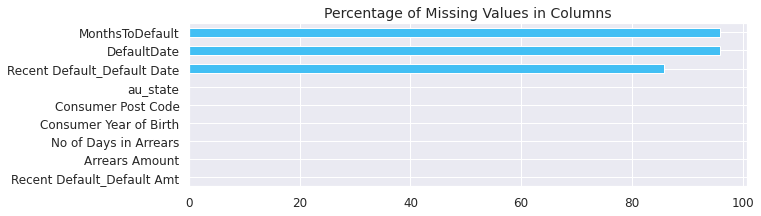

In [394]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 3), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [0]:
# Remove the outlier columns from the dataset / feature summary. 

# columns have more than 80% missing values
missing_80 = missing[missing >80]

# Drop columns that contain 20% missing values
for col in missing_80.index:
  
  # Dataset
  df.drop(col, axis = 1, inplace = True)


In [396]:
df.shape

(276546, 48)

### Step 2.3.2 Rows


In [0]:
# How much data is missing in each row of the dataset?
missing_r = df.isnull().sum(axis=1)

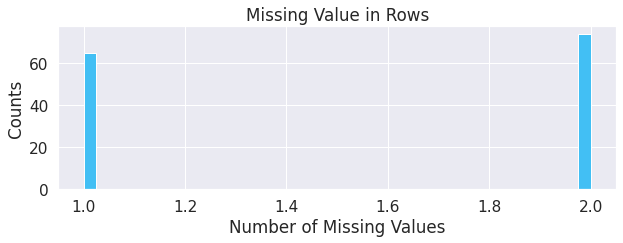

In [398]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,3), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

## Step 2.4 Calculate Percentage

In [0]:
fees = {'Arrears Amount': 'arrear_p',
        'DefaultAmount': 'default_p',
        'Recent Default_Default Amt': 'recent_default_default_p',
        'Recent Default_Recov Amt': 'recent_default_recov_p',
        'Amt Paid To Merchant_nettofmerchfeesandGST': 'gst_p',
        'Est Fees': 'est_fee_p',
        'Other Fees': 'other_fee_p',
        'Total Merchant Charges': 'total_merchant_charge_p',
        'Total Consumer Charges': 'total_consumer_charges'                
        }

In [0]:
# convert amount to percentage
for fee, p in fees.items():
  #print(key, value)
  df[p] = df[fee] / df['Financed Amt']

In [401]:
df.sample(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Total Term,Deposit_Percent,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges
5072,5073,61008185,L61008185,FURN,Default,2006-07-30,2006-05-09,2006H2,2006-09-23,3914.0,978.5,2935.5,24,0.250000,24,0,Bank,52,FN,56.443240,1749.95,1049.1,2549.5,0.1110,325.84,25.0,0,0.0,350.84,30.0,380.84,0.129736,2008-09-23,1208,1049.1,1174.0,1049.1,1185.55,136.45,,3192.0,1986-12-03,30112527,SYDNEY'S FURNITURE CHELTENHAM,Furniture / Bedding New,No,No,VIC,0.357384,0.357384,0.403866,0.046483,0.868506,0.008516,0.0,0.119516,0.01022
26350,26351,60713062,L60713062,,PaidInFull,2006-03-26,2006-03-29,2006H1,2006-04-26,1469.0,500.0,969.0,12,0.340368,12,0,Bank,12,Mth,80.750000,969.00,0.0,848.7,0.0860,83.33,26.0,0,0.0,109.33,0.0,109.33,0.112828,2007-04-26,0,0.0,0.0,0.0,0.00,0.00,,3023.0,1976-12-08,30107105,DAMRO HOME OFFICE FURNITURE,Furniture / Bedding New,No,No,VIC,0.000000,0.000000,0.000000,0.000000,0.875851,0.026832,0.0,0.112828,0.00000
57480,57481,60860696,L60860696,1300 DC,PaidInFull,2006-08-29,2006-05-09,2006H2,2006-09-20,2040.0,680.0,1360.0,12,0.333333,12,0,Bank,12,Mth,113.333333,1360.00,0.0,1196.4,0.0902,122.67,26.0,0,0.0,148.67,0.0,148.67,0.109316,2007-09-20,0,0.0,0.0,0.0,0.00,0.00,,2155.0,1967-05-11,30105465,BERNINA AUSTRALIA PTY LTD,Sewing,No,No,NSW,0.000000,0.000000,0.000000,0.000000,0.879706,0.019118,0.0,0.109316,0.00000


## Step 2.5 Rename Columns

In [0]:
df.rename(columns={'Financed Amt': 'financed_amt', 
                   'Deposit_Percent': 'deposit_percent',
                   'Payment Type': 'payment_type',
                   'Instalment Amt': 'instalment_amt',
                   'Gtee Rate': 'gtee_p',
                   'Effective Billing Rate': 'effective_billing_rate',
                   'No Of Days In Default': 'days_default',
                   'No Of Days In Arrears': 'days_arrears',
                   'MonthsToDefault': 'mth_to_default'              
                   }, 
          inplace=True)

## Step 2.6 Re-Encode Non-Numeric Binary Variable

Re-encode: 2-level obj

`Freq`

* FN: Fortnightly: 0
* Mth: Monthly: 1

`payment_type`

* Bank: 0
* CC: 1

`Homowner Ind`, `Homowner Consumer`
* Yes: 1
* No: 0

In [0]:
# Re-encode: 2-level obj
df['Freq'] = df['Freq'].map({'FN': 0, 'Mth': 1})
df['payment_type'] = df['payment_type'].map({'Bank': 0, 'CC': 1})
df['Homowner Ind'] = df['Homowner Ind'].map({'Yes':1, 'No':0})
df['Homowner Consumer'] = df['Homowner Consumer'].map({'Yes':1, 'No':0})

In [404]:
df.sample(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges
245443,307585,61236942,L61236942,TMILL,PaidInFull,2007-06-15,2007-06-19,2007H1,2007-07-15,1448.0,362.0,1086.0,12,0.250000,12,0,0,24,0,41.762806,1086.0,0.0,957.3,0.0838,91.00,26.0,0,0.0,117.00,0.0,117.00,0.107735,2008-07-15,0,0.0,0.0,0.0,0.0,0.0,,3116.0,1974-03-15,30106386,MANIC FITNESS - CHADSTONE,Fitness Equipment,0,0,VIC,0.0,0.0,0.0,0.0,0.881492,0.023941,0.0,0.107735,0.0
71978,71979,60898678,L60898678,RING,PaidInFull,2006-07-14,2006-07-31,2006H2,2006-08-17,999.0,99.9,899.1,12,0.100000,12,0,0,26,0,34.575450,899.1,0.0,833.2,0.0432,38.84,21.0,0,0.0,59.84,0.0,59.84,0.066555,2007-08-17,0,0.0,0.0,0.0,0.0,0.0,,6169.0,1957-12-25,30107573,SHIELS - ROCKINGHAM,Jewellery,0,0,WA,0.0,0.0,0.0,0.0,0.926704,0.023357,0.0,0.066555,0.0
34712,34713,60770483,L60770483,FURN,PaidInFull,2006-02-18,2006-03-15,2006H1,2006-08-04,2040.0,700.0,1340.0,48,0.343137,48,0,0,48,1,27.916667,1340.0,0.0,1010.8,0.1897,254.19,45.0,0,0.0,299.19,0.0,299.19,0.223276,2010-08-04,0,0.0,0.0,0.0,0.0,0.0,,2905.0,1983-09-15,30106982,NICK SCALI FURNITURE - FYSHWICK,Furniture / Bedding New,0,0,ACT,0.0,0.0,0.0,0.0,0.754328,0.033582,0.0,0.223276,0.0


## Step 2.7 Categorical Variable with more than 2 types

Some of 'PaidInFull' and 'Active' consumers also have arrears.


In [405]:
df['Contract_Status'].value_counts()

PaidInFull    264847
Default        11178
Active           521
Name: Contract_Status, dtype: int64

In [406]:
df[(df['Contract_Status']=='PaidInFull') & (df['recent_default_default_p']>0)]

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges
15,16,30000086,L30000086,ALARM,PaidInFull,2006-11-10,2006-10-25,2006H2,2006-11-30,3172.38,572.38,2600.00,48,0.180426,48,0,0,48,1,54.166667,2600.00,0.0,1965.3,0.2219,576.93,0.00,0,0.0,576.93,30.0,606.93,0.233435,2010-11-30,0,0.0,0.0,0.0,1950.08,84.16,39458,6065.0,1984-02-13,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.750031,0.032369,0.755885,0.000000,0.000000,0.221896,0.011538
18,19,30000090,L30000090,ALARM,PaidInFull,2006-10-21,2006-07-12,2006H2,2006-12-17,3672.38,1072.38,2600.00,48,0.292012,48,0,1,48,1,54.166667,2600.00,0.0,1965.3,0.2219,576.93,0.00,0,0.0,576.93,0.0,576.93,0.221896,2010-12-17,0,0.0,0.0,0.0,1841.76,54.16,39505,6063.0,1964-02-16,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.708369,0.020831,0.755885,0.000000,0.000000,0.221896,0.000000
33,34,30000554,L30000554,ALARM,PaidInFull,2006-10-11,2006-03-12,2006H2,2006-12-25,2671.38,271.38,2400.00,48,0.101588,48,0,0,48,1,50.000000,2400.00,0.0,1814.1,0.2219,532.55,0.00,0,0.0,532.55,0.0,532.55,0.221896,2010-12-25,0,0.0,0.0,0.0,50.00,50.00,40521,2795.0,1924-03-12,30112646,MODERN SECURITY NSW,Home Security,1,1,NSW,0.0,0.0,0.020833,0.020833,0.755875,0.000000,0.000000,0.221896,0.000000
51,52,30000804,L74001920,ALARM,PaidInFull,2006-01-11,2006-08-11,2006H2,2006-11-18,2860.38,290.38,2570.00,48,0.101518,48,0,0,48,1,53.541667,2570.00,0.0,1942.6,0.2219,570.28,0.00,0,0.0,570.28,18.2,588.48,0.228981,2010-11-18,0,0.0,0.0,0.0,714.30,107.08,40182,6107.0,1966-11-12,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.277938,0.041665,0.755875,0.000000,0.000000,0.221899,0.007082
58,59,30000875,L30000875,ALARM,PaidInFull,2006-10-31,2006-08-11,2006H2,2006-11-16,3322.38,722.38,2600.00,48,0.217428,48,0,0,48,1,54.166667,2600.00,0.0,1965.3,0.2219,576.93,0.00,0,0.0,576.93,60.0,636.93,0.244973,2010-11-16,0,0.0,0.0,0.0,84.48,84.48,40521,6112.0,1969-03-26,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.032492,0.032492,0.755885,0.000000,0.000000,0.221896,0.023077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276509,338651,99675744,L99675744,REPAIRS,PaidInFull,2007-06-12,2007-12-19,2007H2,2008-07-01,2335.27,835.27,1500.00,6,0.357676,6,0,0,13,0,115.366867,1500.00,0.0,1345.7,0.0740,110.99,9.75,0,19.5,140.24,60.0,200.24,0.133493,2008-07-07,0,0.0,0.0,0.0,115.44,115.44,39654,6169.0,1972-11-27,30100724,LUBE MOBILE PERTH,Auto Repair / Service,0,0,WA,0.0,0.0,0.076960,0.076960,0.897133,0.006500,0.013000,0.093493,0.040000
276520,338662,99676938,L99676938,REPAIRS,PaidInFull,2007-11-12,2007-12-19,2007H2,2007-12-25,1141.74,300.00,841.74,6,0.262757,6,0,0,6,1,140.290000,841.74,0.0,752.6,0.0740,62.28,9.75,0,9.0,81.03,40.0,121.03,0.143785,2008-06-25,0,0.0,0.0,0.0,701.46,310.58,39546,6059.0,1987-02-24,30100724,LUBE MOBILE PERTH,Auto Repair / Service,0,0,WA,0.0,0.0,0.833345,0.368974,0.894100,0.011583,0.010692,0.096265,0.047521
276529,338671,99677866,L99677866,REPAIRS,PaidInFull,2007-04-24,20

## Step 2.8 Mark people who have had arrears

Is there anyone who have never had arrears?

In [407]:
# Is there anyone who does not have arrears?

df_no_arrears = df[df['recent_default_default_p'] == 0]

no_arrear_p = df_no_arrears.shape[0] / df.shape[0] * 100

print(f"{df_no_arrears.shape[0]} people do not have arrears, occupying {round(no_arrear_p, 2)}%.")

237019 people do not have arrears, occupying 85.71%.


In [0]:
df['has_arrears'] = df['recent_default_default_p'].apply(lambda x: 1 if x > 0 else 0)

How many people have had arrears?

In [409]:
# How many people have had arrears?

df_has_arrears = df[df['recent_default_default_p'] > 0]

has_arrear_p = df_has_arrears.shape[0] / df.shape[0] * 100

print(f"{df_has_arrears.shape[0]} people have had arrears, occupying {round(has_arrear_p, 2)}%.")

39526 people have had arrears, occupying 14.29%.


How many people have recovered arrears?

In [410]:
# How many people have recovered arrears?

df_recov = df[df['recent_default_recov_p'] > 0]

recov_p = df_recov.shape[0] / df.shape[0] * 100

recov_p_2 = df_recov.shape[0] / df_has_arrears.shape[0] * 100

print(f'{df_recov.shape[0]} people have recovered arrears, \
 occupying {round(recov_p, 2)}% of the population \
 and {round(recov_p_2, 2)}% of the people with arrears.')

32146 people have recovered arrears,  occupying 11.62% of the population  and 81.33% of the people with arrears.


In [411]:
print(f'{df_has_arrears.shape[0] - df_recov.shape[0]} people have had arrears but never recovered.')

7380 people have had arrears but never recovered.


How many people have recovered arrears in full?

In [412]:
# How many people have recovered arrears in full?

df_recov_infull = df[df['recent_default_recov_p']==1]

recov_infull_p = df_recov_infull.shape[0] / df.shape[0] * 100

recov_infull_p_2 = df_recov_infull.shape[0] / df_has_arrears.shape[0] * 100

print(f'{df_recov_infull.shape[0]} people have recovered arrears in full,\
 occupying {round(recov_infull_p, 2)}% of the population \
 and {round(recov_infull_p_2, 2)}% of the people with arrears.')

700 people have recovered arrears in full, occupying 0.25% of the population  and 1.77% of the people with arrears.


## 2.10 Age

In [0]:
# Calculate Age: days / 365

df['age'] = df['Application_Date'] - df['Consumer Year of Birth']
df['age'] = df['age'].apply(lambda x: x.days / 365)

## 2.9 Product column

## 2.9.1 contains empty values

In [0]:
# replace empty string with NAN
df['Product'] = df['Product'].replace(r'^\s*$', np.NaN, regex=True)

In [415]:
df['Product'].isnull().sum()

13747

## 2.9.2 similar values

In [0]:
df['Product'].replace('RINGS','RING', inplace = True)
df['Product'].replace(['JEWELLE', 'JEWELLY', 'BRACELE', 'BANGLE'], 'JEWELRY', inplace = True)
df['Product'].replace(['FURNITU', 'FURNITR', 'FURN'], 'FURNITURE', inplace = True)
df['Product'].replace('VAC', 'VACUUM', inplace = True)


In [0]:
df_cleaned = df.copy()

# Step 3 Exploring Data

## 3.0 Consumer Birth Year

In [0]:
# put Year into new columns
df['birth_y'] = df['Consumer Year of Birth'].dt.year

In [0]:
df_0 = df[df['has_arrears']==0]
df_1 = df[df['has_arrears']==1]

The largest birth_y was 2,011.0 and the least was 1906.0.


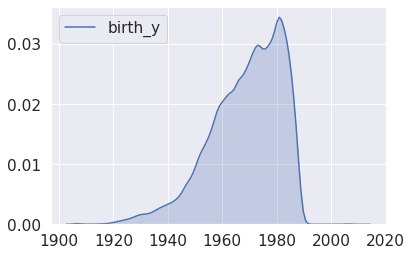

In [420]:
explore_amt('birth_y')

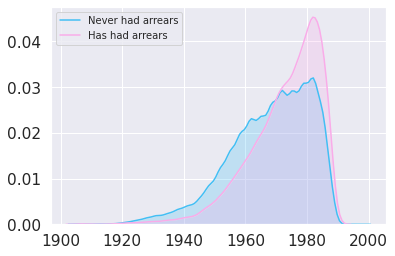

In [421]:
plot_compare_line('birth_y', 2000)

In [422]:
birth_df = get_segments_df_not_from_0(df, 'birth_y', 1940, 1990, 10)
birth_df

,counts
Less than or equals to 1950,14648
1950 (included) to 1960,39611
1960 (included) to 1970,63629
1970 (included) to 1980,81701
1980 (included) to 1990,68205
Equals to or more than 1990,71


In [0]:
birth_df.drop('Equals to or more than 1990', axis=0, inplace=True)

In [0]:
birth_df.rename(index = {'Less than or equals to 1950': 'Earlier than or in 1950'}, inplace = True)

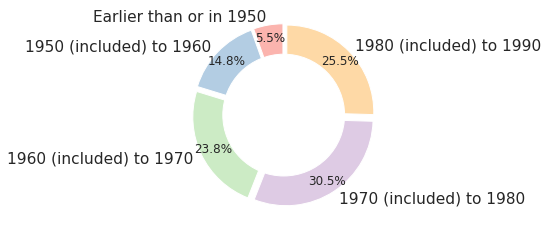

In [425]:
plot_donut(birth_df)

## 3.1 Contracts

* How many contracts in total? For each year? For month? - (bar chart)

In [426]:
print(f"The totla number of contracts is {df.shape[0]:,}.")

The totla number of contracts is 276,546.


In [427]:
print(f"The earlist entry date is {df['Entry_Date'].min()}, whereas the latest is {df['Entry_Date'].max()}.")

The earlist entry date is 2006-01-01 00:00:00, whereas the latest is 2007-12-31 00:00:00.


In [0]:
# put Year into new columns
df['entry_y'] = df['Entry_Date'].dt.year
#df['entry_m'] = df['Entry_Date'].dt.month

# put Year and Month into new columns
df['entry_y_m'] = df['Entry_Date'].dt.to_period('M')

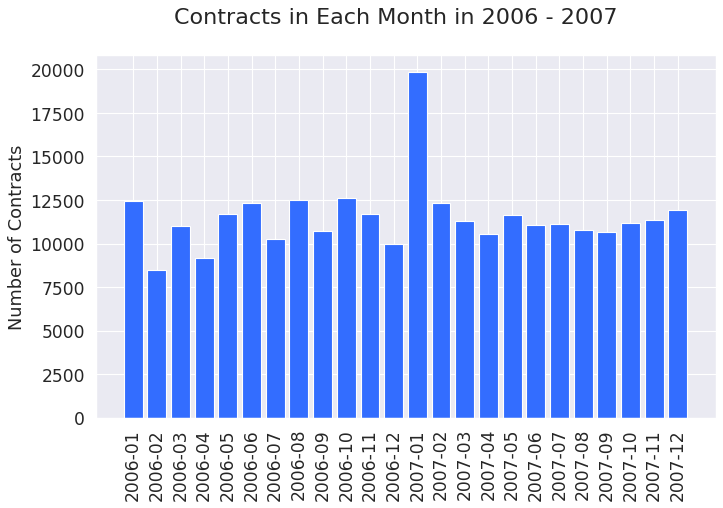

In [429]:
x, y, r = get_agg_df('entry_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 10, 6, 'Contracts in Each Month in 2006 - 2007', '', 'Number of Contracts')

In [0]:
data_df = join_2_df('entry_y_m').sort_index()

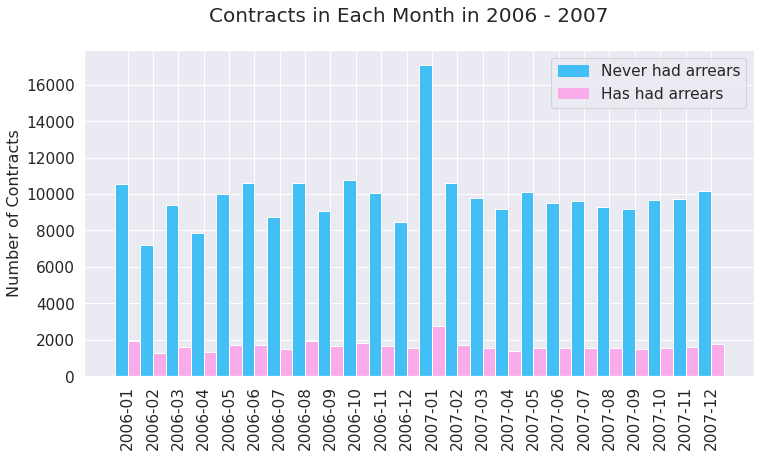

In [431]:
plot_compared_bar_chart(data_df, 12, 6, 90, 'Contracts in Each Month in 2006 - 2007')

In [432]:
x, y, r = get_agg_df('entry_y', 'Contract_Number', "count")
r

,Contract_Number,entry_y
0,132791,2006
1,143755,2007


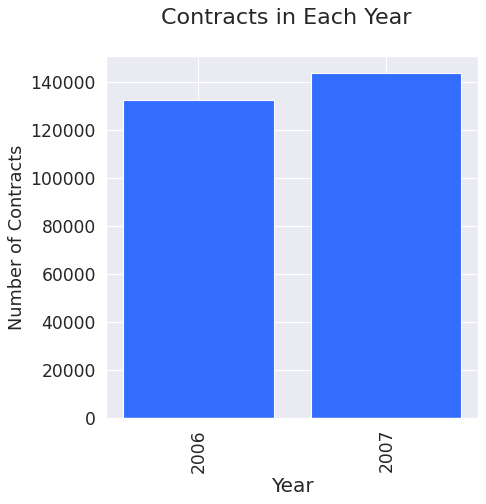

In [433]:
draw_basic_bar_plot(x, y, 6, 6, 'Contracts in Each Year', 'Year', 'Number of Contracts')

## 3.2 Consumers

 

### 3.2.1 How many consumers in total?

In [434]:
df['Consumer_ID'].value_counts()

L61112156    10
L60028728     7
L50016784     7
L60832218     7
L50019007     7
             ..
L60876214     1
L60941029     1
L61263543     1
L61198194     1
L60911366     1
Name: Consumer_ID, Length: 255718, dtype: int64

### 3.2.2 How about the increased rate/number of consumers for each year? For month?

In [0]:
# put Year into new columns
df['app_y'] = df['Application_Date'].dt.year

# put Year and Month into new columns
df['app_y_m'] = df['Application_Date'].dt.to_period('M')

In [436]:
x, y, r = get_agg_df('app_y', 'Consumer_ID', 'count')
r

,Consumer_ID,app_y
0,1,2004
1,8738,2005
2,133882,2006
3,133925,2007


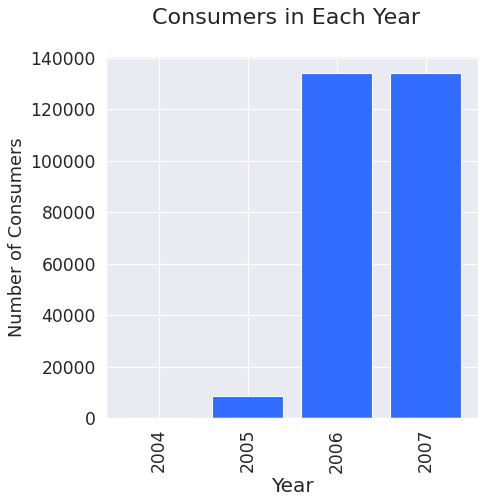

In [437]:
draw_basic_bar_plot(x, y, 6, 6, 'Consumers in Each Year', 'Year', 'Number of Consumers')

In [0]:
x, y, r = get_agg_df('app_y_m', 'Consumer_ID', 'count')

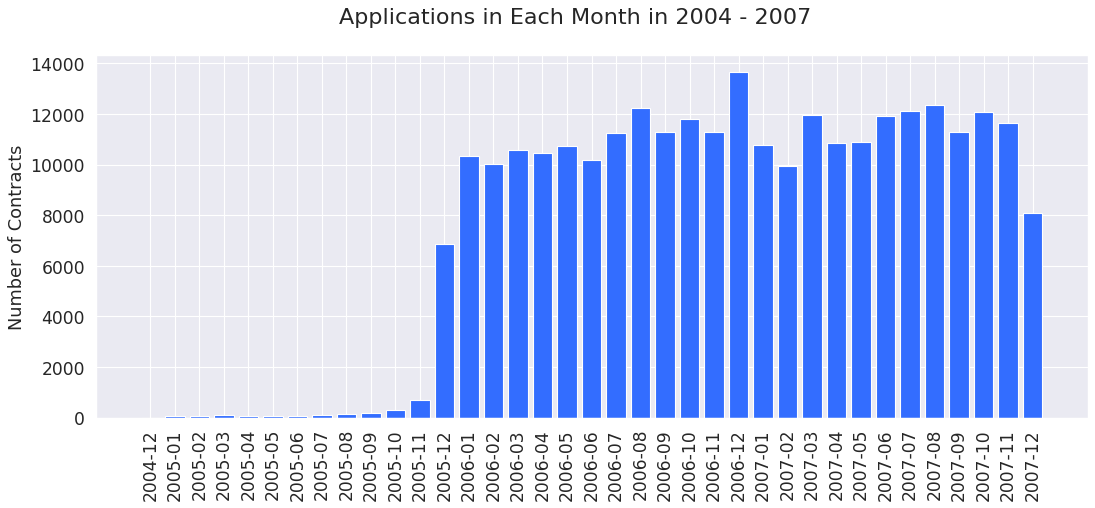

In [439]:
draw_basic_bar_plot(x, y, 16, 6, 'Applications in Each Month in 2004 - 2007', '', 'Number of Contracts')

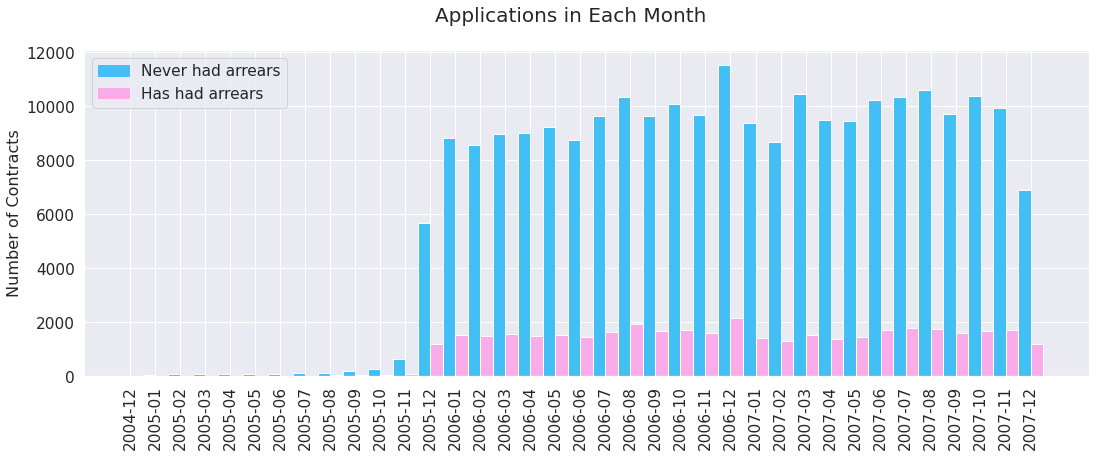

In [440]:
plot_compared_bar_chart(join_2_df('app_y_m').sort_index(), 18, 6, 90, 'Applications in Each Month')

## 3.3 Products

How many products in total? What are the percentages for each product?


In [0]:
product_df = count_types(df, 'Product')

In [442]:
print(f"There are {product_df.shape[0]:,} kinds of products, \
and {product_df[product_df['counts'] >1000].shape[0]} types \
of them were bought more than 1000 times.")

There are 22,723 kinds of products, and 28 types of them were bought more than 1000 times.


In [0]:
# build a new df, with types more than 1000
product_df_new = product_df[product_df['counts'] > 1000]


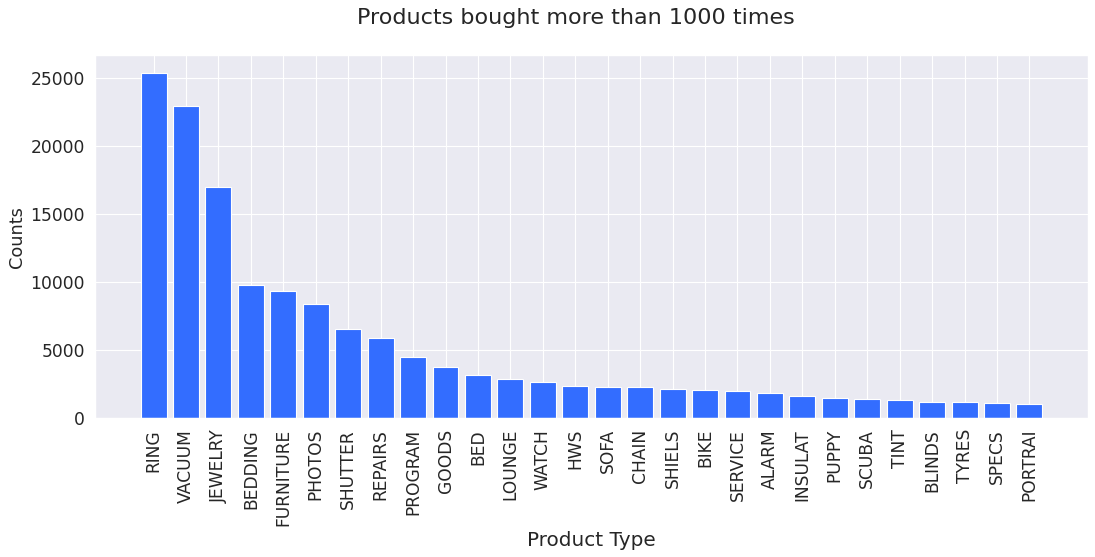

In [444]:
draw_basic_bar_plot(
    product_df_new.index.to_list(),
    product_df_new['counts'].to_list(),
    16, 6,
    "Products bought more than 1000 times", "Product Type", "Counts"
)

## 3.4 Contract Status

How many types of Contract_status? What are the percentages for every status? (pie chart)

In [0]:
contract_status_df = count_types(df, 'Contract_Status')

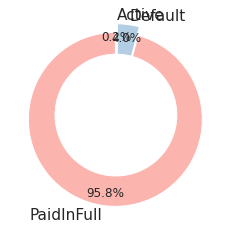

In [446]:
plot_donut(contract_status_df)

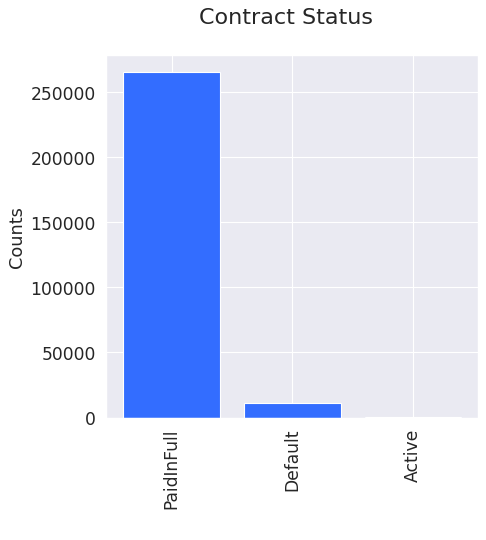

In [447]:
draw_basic_bar_plot(
    contract_status_df.index.to_list(),
    contract_status_df['counts'].to_list(),
    6, 6,
    "Contract Status", " ", "Counts"
)

In [448]:
contract_status_df

,counts
type,
PaidInFull,264847
Default,11178
Active,521


In [449]:
n = contract_status_df[contract_status_df['counts'] < 100000].sum()
contract_status_df.drop(['Default', 'Active'], inplace = True)
contract_status_df.loc['Other types'] = [n]
contract_status_df

,counts
type,
PaidInFull,264847
Other types,counts 11699 dtype: int64


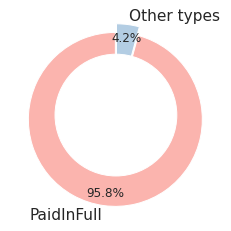

In [450]:
plot_donut(contract_status_df)

## 3.7 StartHalf

What are the percentages for each “StartHalf”

In [0]:
start_half_df = count_types(df,'StartHalf')

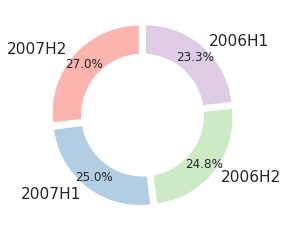

In [452]:
plot_donut(start_half_df)

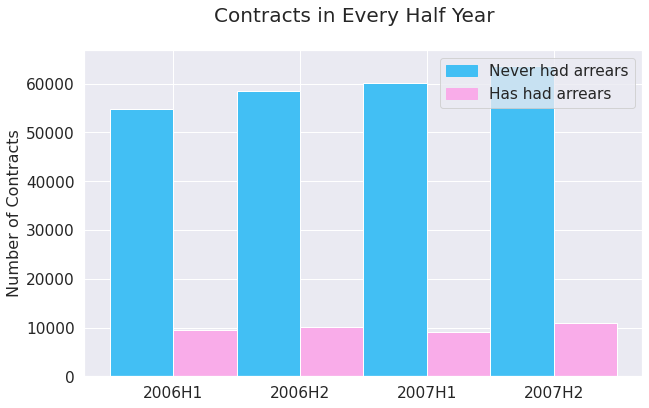

In [453]:
plot_compared_bar_chart(join_2_df('StartHalf').sort_index(), 10, 6, 0, 'Contracts in Every Half Year')

## 3.8 First Installment Date

What are the number and percentages of “First Installment Date" for each month?

In [0]:
# put Year and Month into new columns
df['install_y_m'] = df['Fist Installment Date'].dt.to_period('M')

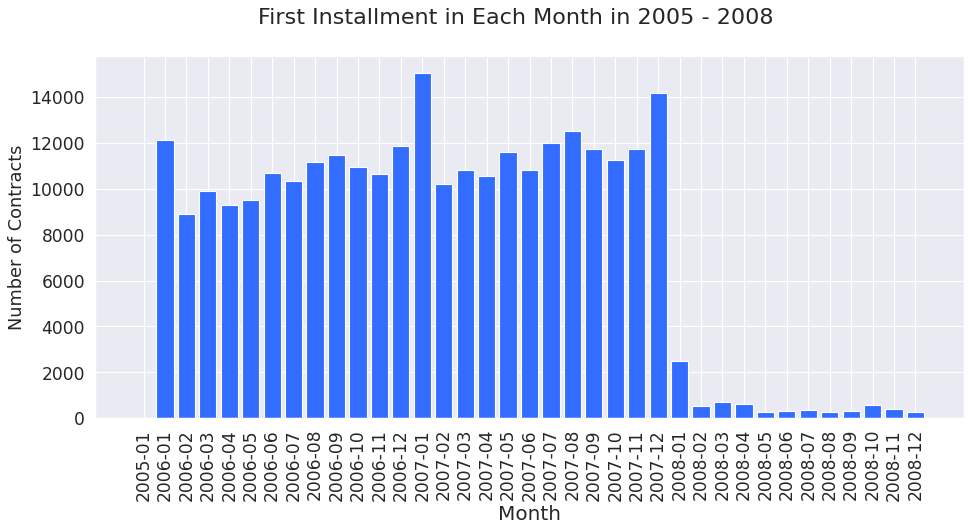

In [613]:
x, y, r = get_agg_df('install_y_m', 'Contract_Number', "count")
draw_basic_bar_plot(x, y, 14, 6, 'First Installment in Each Month', 'Month', 'Number of Contracts')

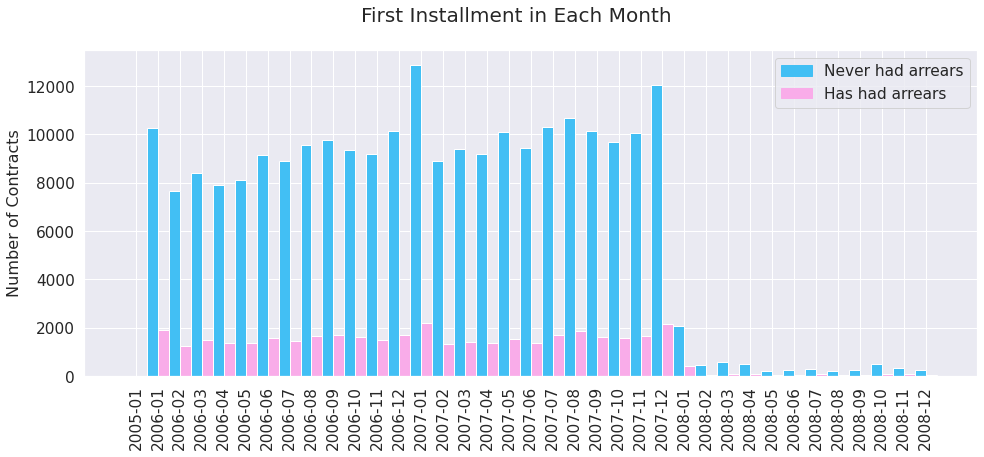

In [621]:
plot_compared_bar_chart(join_2_df('install_y_m').sort_index(), 16, 6, 90, 'First Installment in Each Month')

## 3.15 Payment Type

What are the types in “payment Types”, and what are the percentages for each “payment type”?

In [0]:
pay_df = count_types(df, 'payment_type')

In [0]:
pay_df['type'] = ['Bank', 'CC']
pay_df.set_index('type', inplace = True)

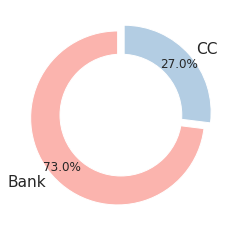

In [459]:
plot_donut(pay_df)

In [0]:
pay_df_2 = join_2_df('payment_type')
pay_df_2['type'] = ['Bank', 'CC']
pay_df_2.set_index('type', inplace = True)

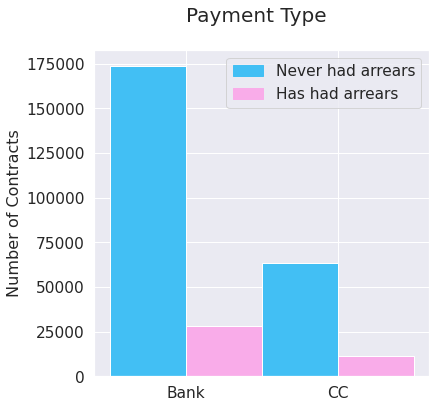

In [624]:
plot_compared_bar_chart(pay_df_2, 6, 6,0, 'Payment Type')

## 3.9 Purchased Amount

Purchase amt segments? $100-500, $500-1000, $ 1500-2000,….And percentages of each segments?

The largest Purchase Amt was 54,052.0 and the least was 70.0.


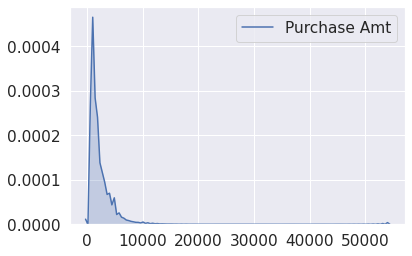

In [462]:
explore_amt('Purchase Amt')

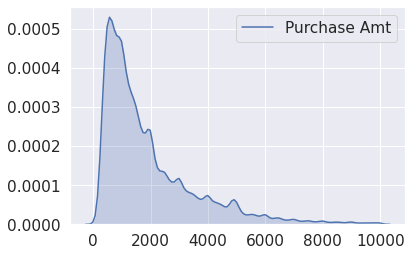

In [463]:
explore_amt_range('Purchase Amt',10000)

In [0]:
purchase_amt_df = get_segments_df(df,'Purchase Amt', 6000, 2000)

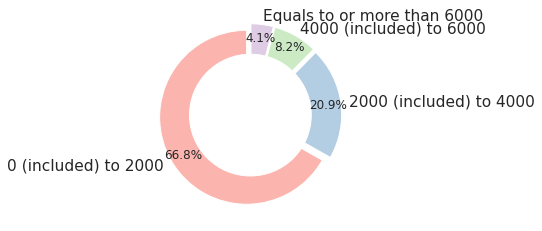

In [465]:
plot_donut(purchase_amt_df)

In [0]:
def get_compared_numeric_df(col, start, end, step):

  # separate df
  df_0 = df[df['has_arrears']==0]
  df_1 = df[df['has_arrears']==1]

  # get new df
  new_df_0 = get_segments_df_not_from_0(df_0, 'Purchase Amt', 0,  6000, 2000)
  new_df_0.columns = ['no_arrears']

  # get new df
  new_df_1 = get_segments_df_not_from_0(df_1, 'Purchase Amt', 0,  6000, 2000)
  new_df_1.columns = ['has_arrears']

  # join 2 df
  combined_df = new_df_0.join(new_df_1, how='outer')

  return combined_df



In [0]:
amt_df = get_compared_numeric_df('Purchase Amt', 0,  6000, 2000)

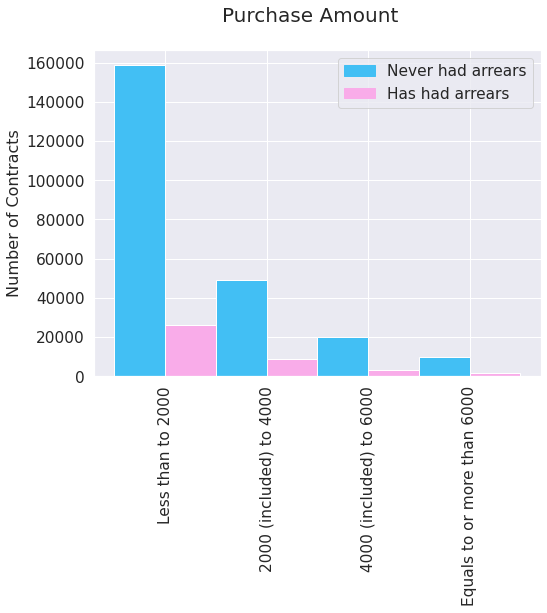

In [665]:
plot_compared_bar_chart(amt_df, 8, 6, 90, "Purchase Amount")

In [0]:
new_df_0 = get_segments_df_not_from_0(df_0, 'Purchase Amt', 0,  6000, 2000)
new_df_0.columns = ['no_arrears']


In [642]:
new_df_0

,no_arrears
Less than or equals to 2000,158555
2000 (included) to 4000,48839
4000 (included) to 6000,19685
Equals to or more than 6000,9941


In [0]:
new_df_1 = get_segments_df_not_from_0(df_1, 'Purchase Amt', 0,  6000, 2000)
new_df_1.columns = ['has_arrears']

In [645]:
combined_df = new_df_0.join(new_df_1, how='outer')
combined_df

,no_arrears,has_arrears
Less than or equals to 2000,158555,26136
2000 (included) to 4000,48839,8821
4000 (included) to 6000,19685,3040
Equals to or more than 6000,9941,1529


## 3.10 Financed amt 

Financed amt segments? And percentages of each segments?

The largest financed_amt was 15,000.0 and the least was 50.0.


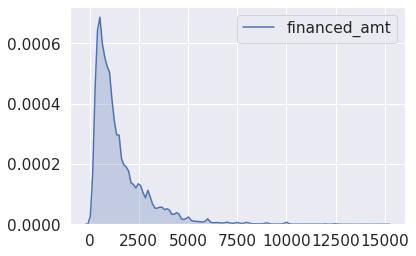

In [466]:
explore_amt('financed_amt')

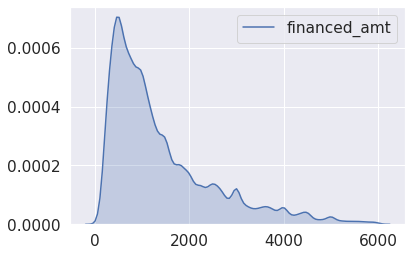

In [467]:
explore_amt_range('financed_amt', 6000)

In [0]:
financed_amt_df = get_segments_df(df,'financed_amt', 4000, 1000)

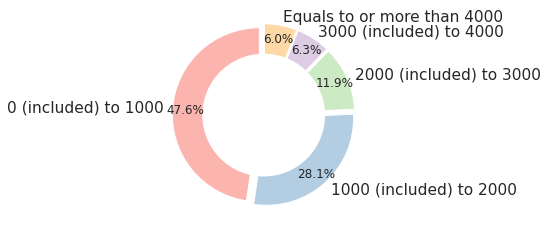

In [469]:
plot_donut(financed_amt_df)

## 3.11 Total Term


The largest Total Term was 48 and the least was 2.


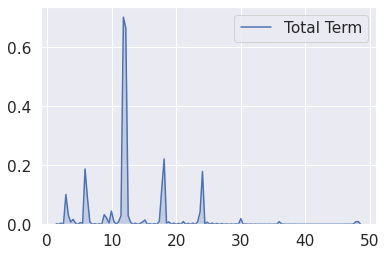

In [470]:
explore_amt('Total Term')

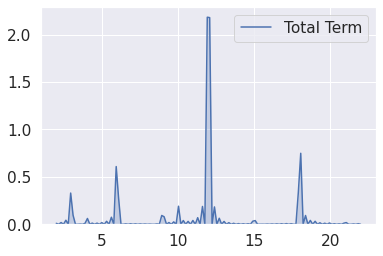

In [471]:
explore_amt_range("Total Term", 24)

In [0]:
term_df = get_segments_df(df, 'Total Term', 24, 8)

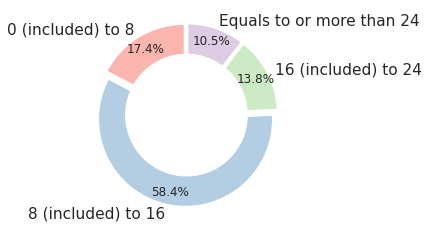

In [473]:
plot_donut(term_df)

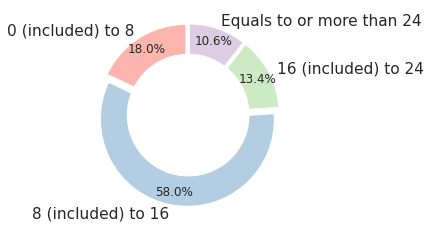

In [474]:
term_df_0 = get_segments_df(df_0, 'Total Term', 24, 8)
plot_donut(term_df_0)

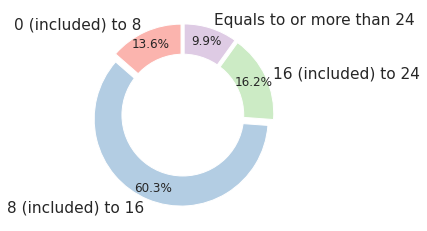

In [475]:
term_df_1 = get_segments_df(df_1, 'Total Term', 24, 8)
plot_donut(term_df_1)

## 3.12 Deposit_precent

The largest deposit_percent was 0.9697812 and the least was 0.0.


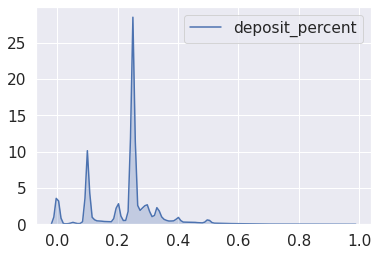

In [476]:
explore_amt('deposit_percent')

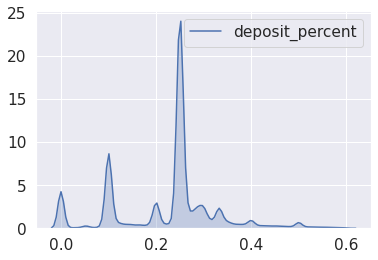

In [477]:
explore_amt_range('deposit_percent', 0.6)

In [0]:
deposit_percent_df = get_pct_segments_df(df, 'deposit_percent', 0.4, 0.2)

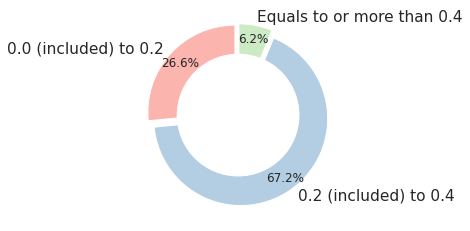

In [479]:
plot_donut(deposit_percent_df)

In [0]:
deposit_percent_df_0 = get_pct_segments_df(df_0, 'deposit_percent', 0.4, 0.2)

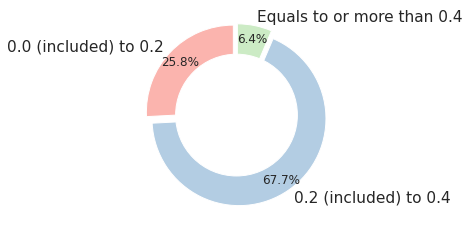

In [481]:
plot_donut(deposit_percent_df_0)

In [0]:
deposit_percent_df_1 = get_pct_segments_df(df_1, 'deposit_percent', 0.4, 0.2)

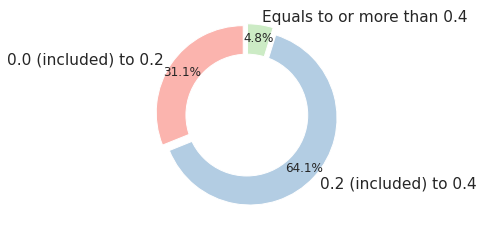

In [483]:
plot_donut(deposit_percent_df_1)

## 3.13 Term_Run

The largest Term_Run was 48 and the least was 2.


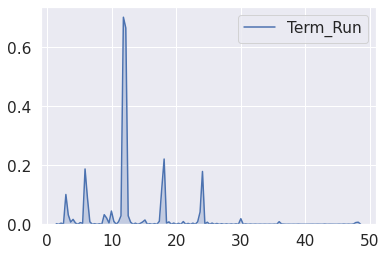

In [484]:
explore_amt('Term_Run')

In [0]:
Term_Run_df = get_segments_df(df, 'Term_Run', 24, 8)

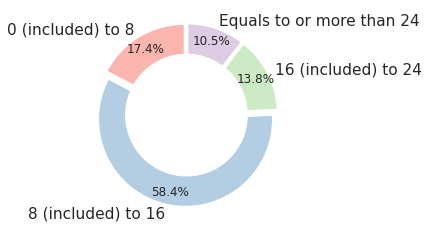

In [486]:
plot_donut(Term_Run_df)

## 3.14 Term_Remaining

The largest Term_Remaining was 10 and the least was 0.


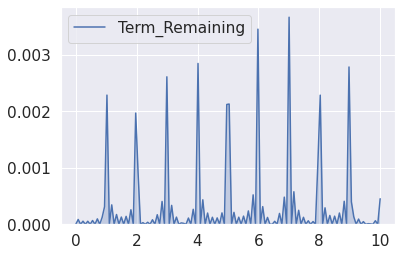

In [487]:
explore_amt('Term_Remaining')

In [0]:
Term_Remaining_df = get_segments_df(df, 'Term_Remaining', 2, 2)

In [489]:
Term_Remaining_df

,counts
0 (included) to 2,276074
Equals to or more than 2,472


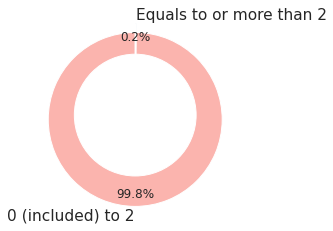

In [490]:
plot_donut(Term_Remaining_df)

In [491]:
df['Term_Remaining'].value_counts()

0     276025
5         80
8         63
6         62
9         60
7         56
2         54
4         51
1         49
3         40
10         6
Name: Term_Remaining, dtype: int64

## 3.16 Total No of Payments

In [492]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age,birth_y,entry_y,entry_y_m,app_y,app_y_m,install_y_m
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,1965.3,0.2219,576.93,0.0,0,0.0,576.93,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530.0,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.0,0.0,0.755885,0.0,0.0,0.221896,0.0,0,45.928767,1960.0,2006,2006-01,2006,2006-10,2006-11


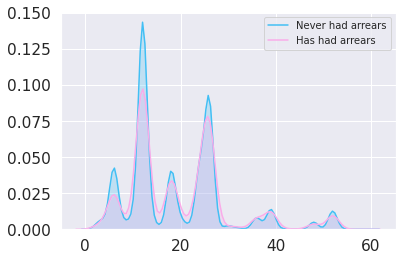

In [493]:
plot_compare_line('Total No Of Payments', 60)

In [0]:
payment_no_df = get_segments_df(df, 'Total No Of Payments', 40, 20)

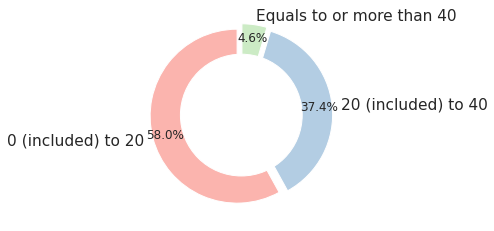

In [495]:
plot_donut(payment_no_df)

## 3.18 Installment Amt

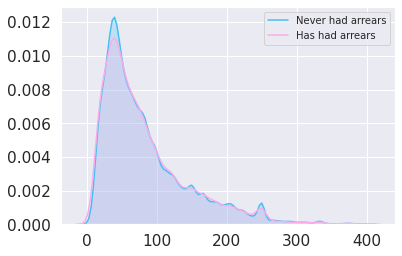

In [496]:
plot_compare_line('instalment_amt', 400)


In [0]:
instal_df = get_segments_df(df, 'instalment_amt', 200, 100)

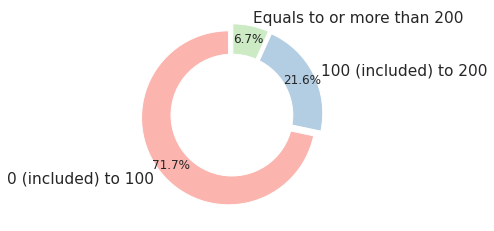

In [498]:
plot_donut(instal_df)

## 3.19 Total Payment Received

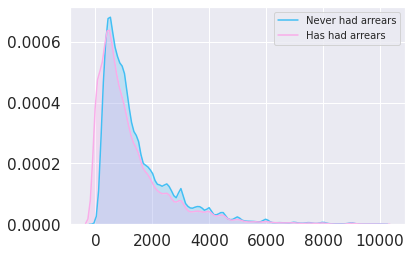

In [499]:
plot_compare_line('Total Payments Received', 10000)

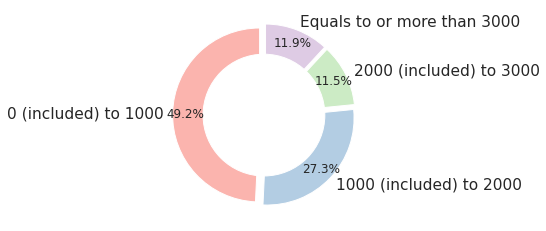

In [500]:
received_df = get_segments_df(df, 'Total Payments Received', 3000, 1000)

plot_donut(received_df)

## 3.20 Total Balance Outstanding


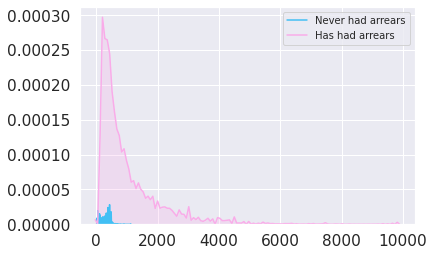

In [501]:
plot_compare_line('Total Balance Outstanding', 10000)

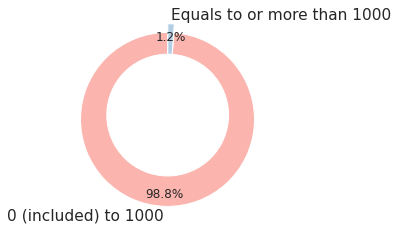

In [502]:
outstanding_df = get_segments_df(df, 'Total Balance Outstanding', 1000, 1000)

plot_donut(outstanding_df)

## 3.21 Amt Paid to Merchant and GST

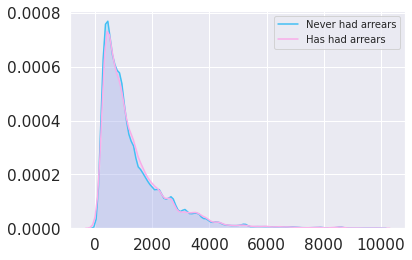

In [503]:
plot_compare_line('Amt Paid To Merchant_nettofmerchfeesandGST', 10000)

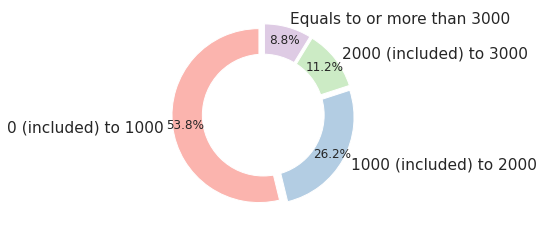

In [504]:
gst_df = get_segments_df(df, 'Amt Paid To Merchant_nettofmerchfeesandGST', 3000, 1000)

plot_donut(gst_df)

## 3.22 GTEE charges

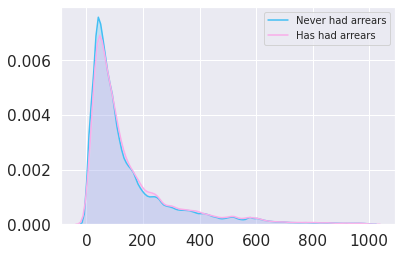

In [505]:
plot_compare_line('Gtee Charges', 1000)

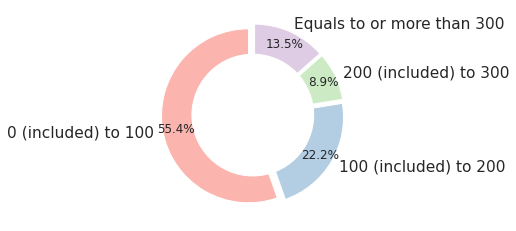

In [506]:
gtee_df = get_segments_df(df, 'Gtee Charges', 300, 100)

plot_donut(gtee_df)

## 3.24 Establish Fee

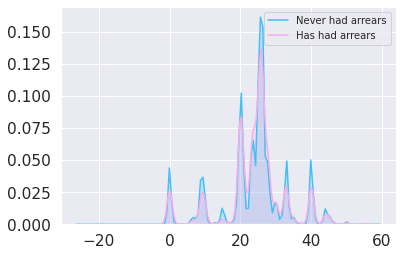

In [507]:
plot_compare_line('Est Fees', 10000)

In [508]:
df['Est Fees'].min()

-25.0

In [0]:
est_df = get_segments_df_not_from_0(df, 'Est Fees', 0, 40, 10)

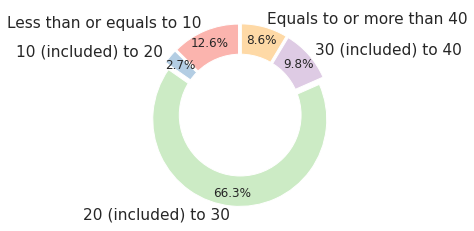

In [510]:
plot_donut(est_df)

## 3.25 Proc Fee

In [511]:
df['Proc Fees'].max()

0

In [512]:
df['Proc Fees'].min()

0

## 3.26 Other fee

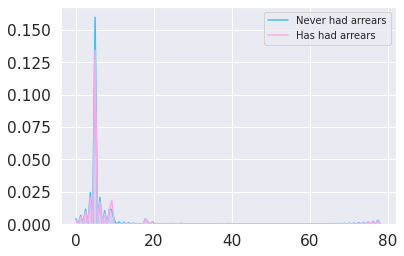

In [513]:
plot_compare_line('Other Fees', 100)

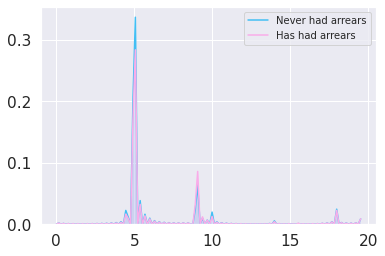

In [514]:
plot_compare_line('Other Fees', 20)

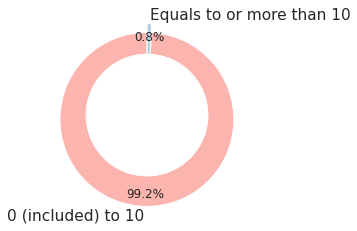

In [515]:
other_fee_df = get_segments_df(df, 'Other Fees', 10, 10)

plot_donut(other_fee_df)

## 3.27 Total Merchant Charge

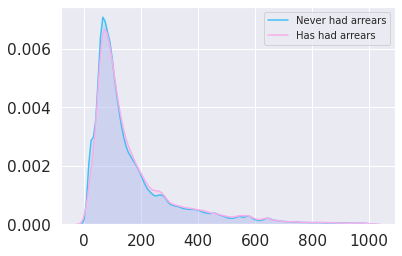

In [516]:
plot_compare_line('Total Merchant Charges', 1000)

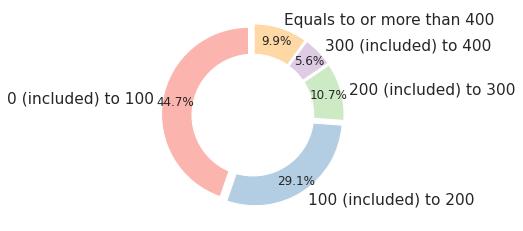

In [517]:
mer_df = get_segments_df(df, 'Total Merchant Charges', 400, 100)

plot_donut(mer_df)

## 3.28 Total Consumer Charges

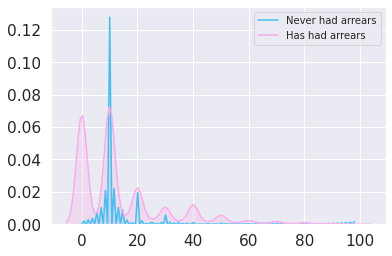

In [518]:
plot_compare_line('Total Consumer Charges', 100)

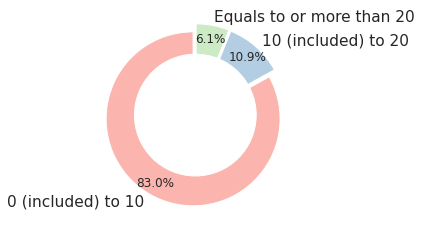

In [519]:
cust_df = get_segments_df(df, 'Total Consumer Charges', 20, 10)

plot_donut(cust_df)

## 3.29 Total Charges

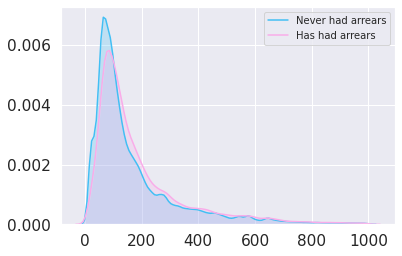

In [520]:
plot_compare_line('Total Charges', 1000)

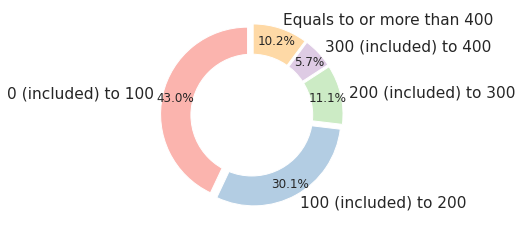

In [521]:
char_df = get_segments_df(df, 'Total Charges', 400, 100)

plot_donut(char_df)

## 3.32 days_default

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


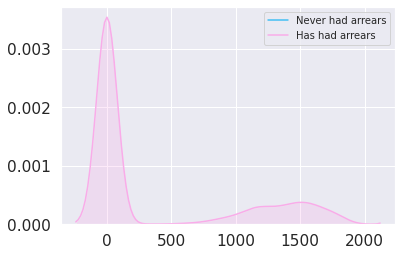

In [522]:
plot_compare_line('days_default', 10000)

In [523]:
df['days_default'].max()

1879

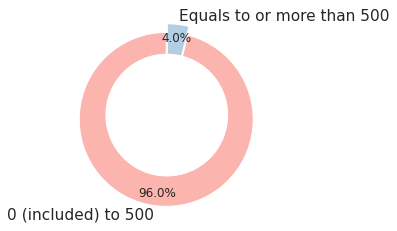

In [524]:
default_d_df = get_segments_df(df, 'days_default', 500, 500)

plot_donut(default_d_df)

## 3.33 Arrears Amount

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


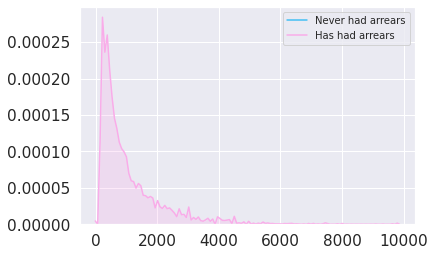

In [525]:
plot_compare_line('Arrears Amount', 10000)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


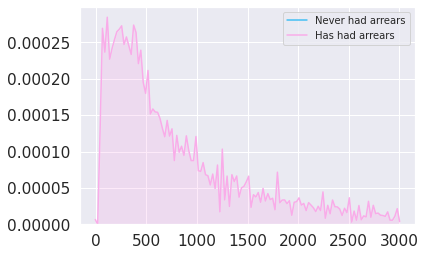

In [526]:
plot_compare_line('Arrears Amount', 3000)

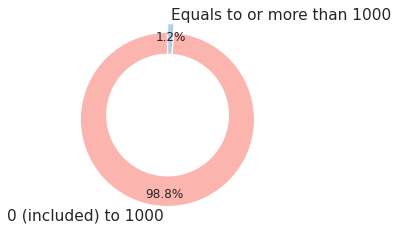

In [527]:
arr_amt_df = get_segments_df(df, 'Arrears Amount', 1000, 1000)

plot_donut(arr_amt_df)

## 3.34 No of Days in Arrears

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


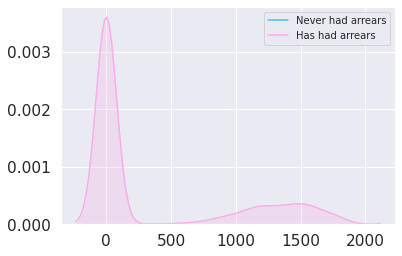

In [528]:
plot_compare_line('No of Days in Arrears', 3000)

In [529]:
df['No of Days in Arrears'].value_counts()

0.0       265373
1432.0        37
1530.0        36
1523.0        36
1151.0        34
           ...  
486.0          1
667.0          1
506.0          1
521.0          1
776.0          1
Name: No of Days in Arrears, Length: 1330, dtype: int64

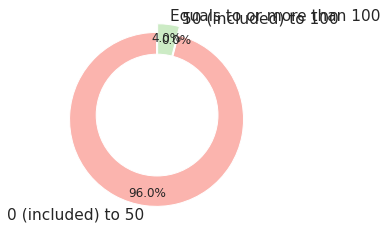

In [530]:
arr_d_df = get_segments_df(df, 'No of Days in Arrears', 100, 50)

plot_donut(arr_d_df)

## 3.35 Default Amount

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


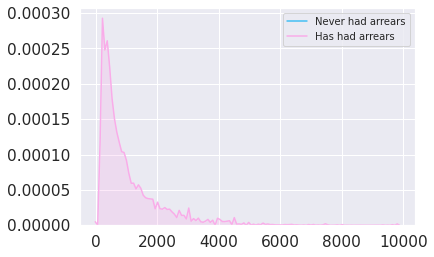

In [531]:
plot_compare_line('DefaultAmount', 10000)

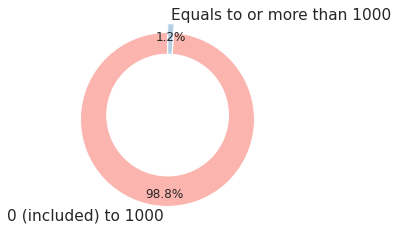

In [532]:
default_amt_df = get_segments_df(df, 'DefaultAmount', 1000, 1000)

plot_donut(default_amt_df)

## 3.36 Number of Default in each year / month

In [533]:
df.sample(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age,birth_y,entry_y,entry_y_m,app_y,app_y_m,install_y_m
253701,315843,61259599,L60751017,------.,PaidInFull,2007-10-27,2007-07-11,2007H2,2007-11-24,1425.0,357.0,1068.0,12,0.250526,12,0,0,12,1,89.0,1068.0,0.0,940.7,0.0849,90.67,25.0,0,0.0,115.67,0.0,115.67,0.108305,2008-11-24,0,0.0,0.0,0.0,0.0,0.0,,4350.0,1969-01-21,30105555,MICHAEL HILL JEWELLER - GRAND CENTRAL (406),Jewellery,0,0,QLD,0.0,0.0,0.0,0.0,0.880805,0.023408,0.0,0.108305,0.0,0,38.789041,1969.0,2007,2007-07,2007,2007-10,2007-11


## 3.37 Postcode

In [0]:
x, y, r = get_agg_df('au_state', 'Contract_Number', "count")

In [535]:
r.sort_values(by=['Contract_Number'], ascending=False, inplace= True)
r

,Contract_Number,au_state
3,88292,QLD
1,70628,NSW
6,50257,VIC
7,30975,WA
4,25487,SA
5,4411,TAS
0,4056,ACT
2,2359,NT


In [0]:
y = r['Contract_Number'].tolist()
x = r['au_state'].tolist()

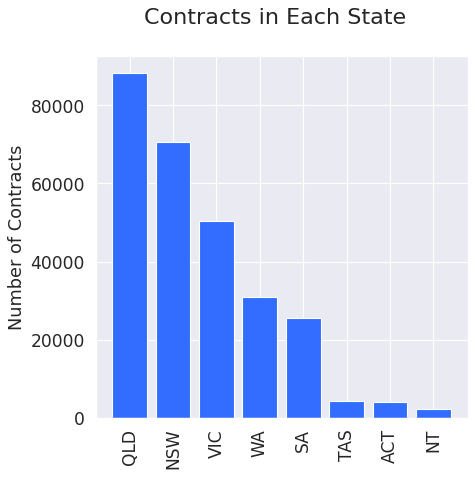

In [537]:
draw_basic_bar_plot(x, y, 6, 6, 'Contracts in Each State', '', 'Number of Contracts')

In [0]:
r = count_types(df, 'au_state')
r.loc['Other'] = r[r['counts']<10000].sum()

In [539]:
r = r[r['counts']>10000]
r

,counts
type,
QLD,88292
NSW,70628
VIC,50257
WA,30975
SA,25487
Other,10826


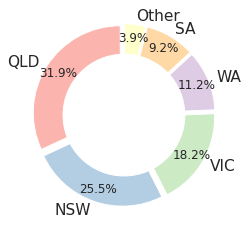

In [540]:
plot_donut(r)

## Merchant Numbers

In [541]:
df['Merchant Number'].value_counts()

30107010    1951
30107777    1736
30108836    1703
30106156    1691
30106666    1601
            ... 
30108273       1
30114322       1
30108009       1
30114619       1
30111964       1
Name: Merchant Number, Length: 5406, dtype: int64

In [0]:
x,y,r = get_agg_df('Merchant Number','Contract_Number', 'count')

In [0]:
r.sort_values(by=['Contract_Number'], ascending = False, inplace=True)

In [0]:
mer_df = r[r['Contract_Number'] > 1000]

In [0]:
x = mer_df['Merchant Number'].tolist()
y = mer_df['Contract_Number'].tolist()

In [0]:
def get_mer(col, n):
  x,y,r = get_agg_df(col,'Contract_Number', 'count')
  r.sort_values(by=['Contract_Number'], ascending = False, inplace=True)
  mer_df = r[r['Contract_Number'] > n]
  x = mer_df[col].tolist()
  y = mer_df['Contract_Number'].tolist()
  return x, y

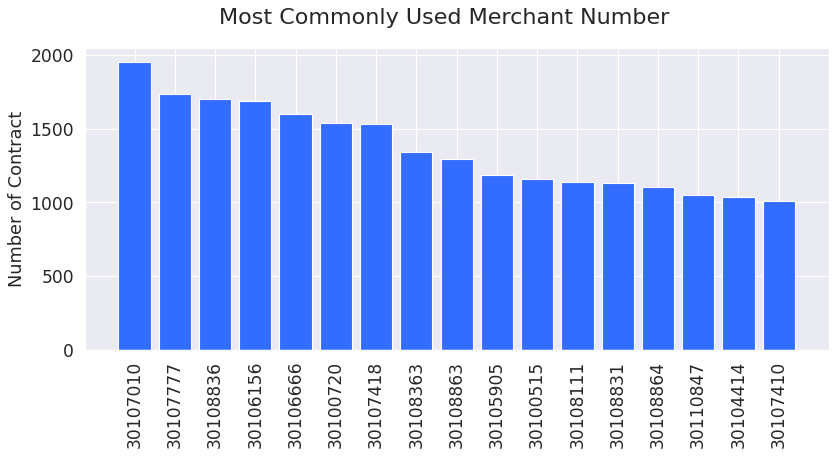

In [547]:
draw_basic_bar_plot(x, y, 12, 5, 'Most Commonly Used Merchant Number', '', 'Number of Contract')

## 3.40 Merchant Name

In [548]:
df['Merchant Name'].value_counts()

MODERN ROOF RESTORATION (NSW) PTY LTD    1951
WENATEX NSW                              1736
AGL ASSIST VIC                           1703
CRAFTMATIC AUSTRALIA                     1691
WENATEX AUSTRALIA PTY LTD                1601
                                         ... 
CHALLENGER FORD - AFTERMARKET               1
RANBUILD - OUTDOOR WORLD LANCELIN           1
DIGITAL ARTS COMPUTERS                      1
BLUE HAVEN POOLS & SPAS - TUGGERAH          1
RENATO DESIGNER JEWELLERS                   1
Name: Merchant Name, Length: 5173, dtype: int64

In [0]:
x, y = get_mer('Merchant Name', 1000)

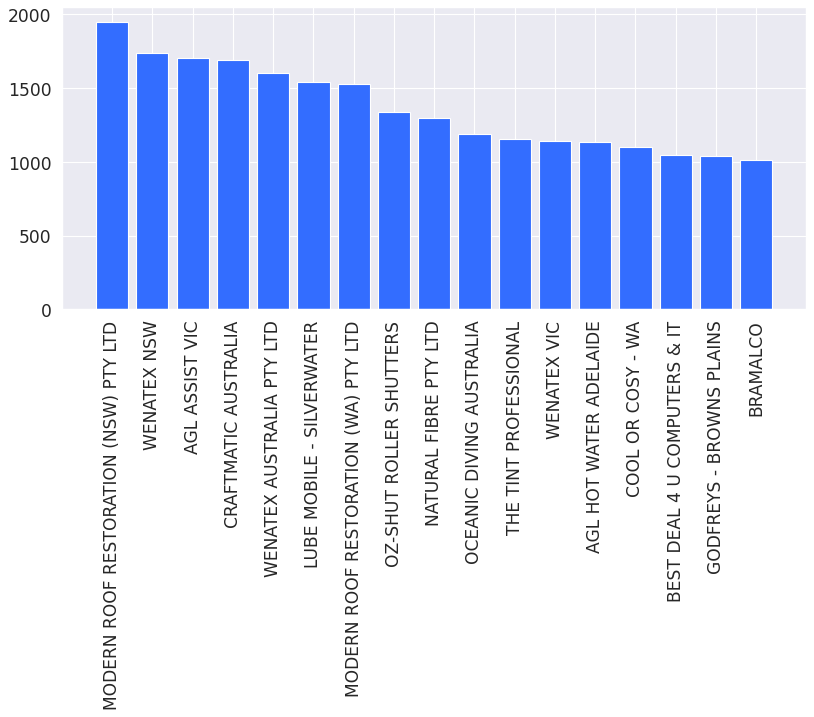

In [550]:
draw_basic_bar_plot(x, y, 12, 5, '', '', '')

## Industry

In [551]:
df.sample(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age,birth_y,entry_y,entry_y_m,app_y,app_y_m,install_y_m
87295,87296,60937790,L60937790,NaN,PaidInFull,2006-05-27,2006-08-06,2006H1,2006-06-27,1425.0,357.0,1068.0,18,0.250526,18,0,0,18,1,59.333333,1068.0,0.0,904.0,0.1138,121.53,27.5,0,0.0,149.03,10.0,159.03,0.148904,2007-12-27,0,0.0,0.0,0.0,356.04,356.04,39791,2229.0,1982-12-20,30100846,MICHAEL HILL JEWELLER - HURSTVILLE (289),Jewellery,0,0,NSW,0.0,0.0,0.333371,0.333371,0.846442,0.025749,0.0,0.139541,0.009363,1,23.449315,1982.0,2006,2006-08,2006,2006-05,2006-06


In [552]:
df['INdustry Name'].value_counts()

Jewellery                  96583
Furniture / Bedding New    36041
Vacuums                    27635
Photo Studio               13506
Auto Repair / Service      11324
                           ...  
Hair and Beauty               15
Electrical Browngoods         10
Fencing/Steel                  6
Office Equipment               3
Tiles Wooden Floors            1
Name: INdustry Name, Length: 68, dtype: int64

In [0]:
x, y = get_mer('INdustry Name', 1000)

In [554]:
x

['Jewellery',
 'Furniture / Bedding New',
 'Vacuums',
 'Photo Studio',
 'Auto Repair / Service',
 'Fitness Equipment',
 'Roofing / Shutters / Gutters',
 'Weightloss',
 'Hot Water / Gas',
 'Air Conditioning / Heating',
 'Computers',
 'Solar Energy',
 'Musical Instruments',
 'Bicycles',
 'Aquarium / Pet Stores',
 'Diving / Skiing',
 'New Car Servicing  & Aftermkt.',
 'Optometrists',
 'Home Security',
 'Medical Services',
 'Auto Specialty',
 'Vetinary Clinics',
 'Pools and Spas',
 'Curtains / Blinds / Tinting',
 'Tyres',
 'Sheds & Carports',
 'Mowers',
 'Patio / Pergola',
 'Ladies Fashion < 30']

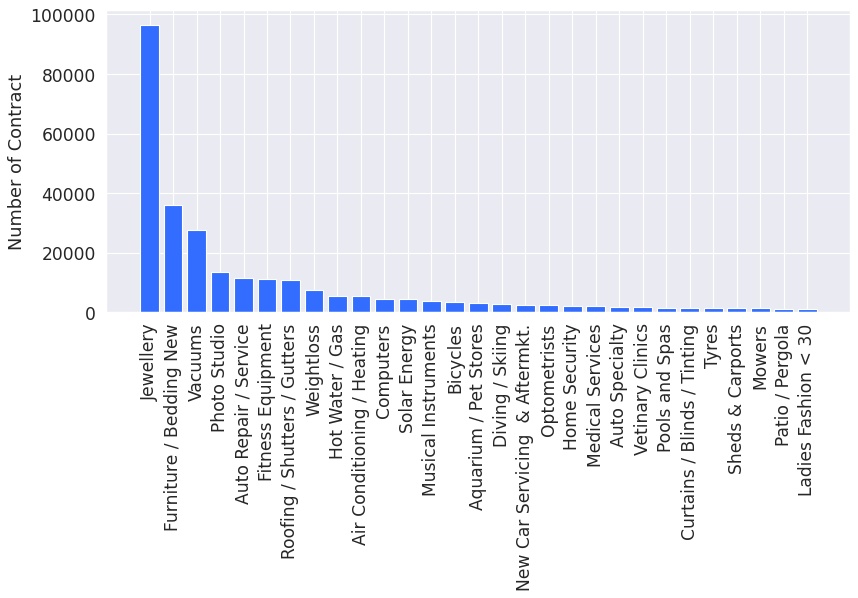

In [555]:
draw_basic_bar_plot(x, y, 12, 5, '', '', 'Number of Contract')

## homeowner

In [556]:
df.sample(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age,birth_y,entry_y,entry_y_m,app_y,app_y_m,install_y_m
85195,85196,60932885,L60932885,BOFA,PaidInFull,2006-05-22,2006-06-14,2006H1,2006-06-24,2448.0,0.0,2448.0,18,0.0,18,0,0,36,0,62.759575,2448.0,0.0,2122.2,0.1075,263.15,33.0,0,0.0,296.15,0.0,296.15,0.120976,2007-12-24,0,0.0,0.0,0.0,0.0,0.0,,3631.0,1984-04-16,30107890,OZ DESIGN SHEPPARTON,Furniture / Bedding New,0,0,VIC,0.0,0.0,0.0,0.0,0.866912,0.01348,0.0,0.120976,0.0,0,22.112329,1984.0,2006,2006-06,2006,2006-05,2006-06


In [557]:
df[df['Homowner Ind'] == 1]['Homowner Ind'].sum()

36107

In [558]:
df[df['Homowner Consumer'] == 1]['Homowner Consumer'].sum()

42599

# Step 4. Correlation

## Correlation

In [0]:
df = df_cleaned.copy()

In [0]:
features = ['financed_amt',      #贷款金额
            'deposit_percent',   #首付比例
            'payment_type',      #还款方式
            'Freq',              #还款频率
            'gst_p',             #GST和商家手续费费率 （占贷款金额的比例，以下同）
            'gtee_p',            #银行担保费率
            'est_fee_p',         #开户费率
            'other_fee_p',       #其他费用费率
            #'total_merchant_charge_p',   #以上各种费率总和
            'total_consumer_charges',    #客户所付费用费率
            #'effective_billing_rate',    #全部费率之和
            #'days_default',	     #
            #'arrear_p',          #应还金额所占比例
            #'days_arrears',	    
            #'default_p',         #初始逾期金额所占比例
            #'mth_to_default',
            'recent_default_default_p',  #最近一次逾期金额所占比例          
            #'recent_default_recov_p',    #最近一次还款金额所占比例
            'age'                #年龄
]

In [0]:
df_cor = df[features]

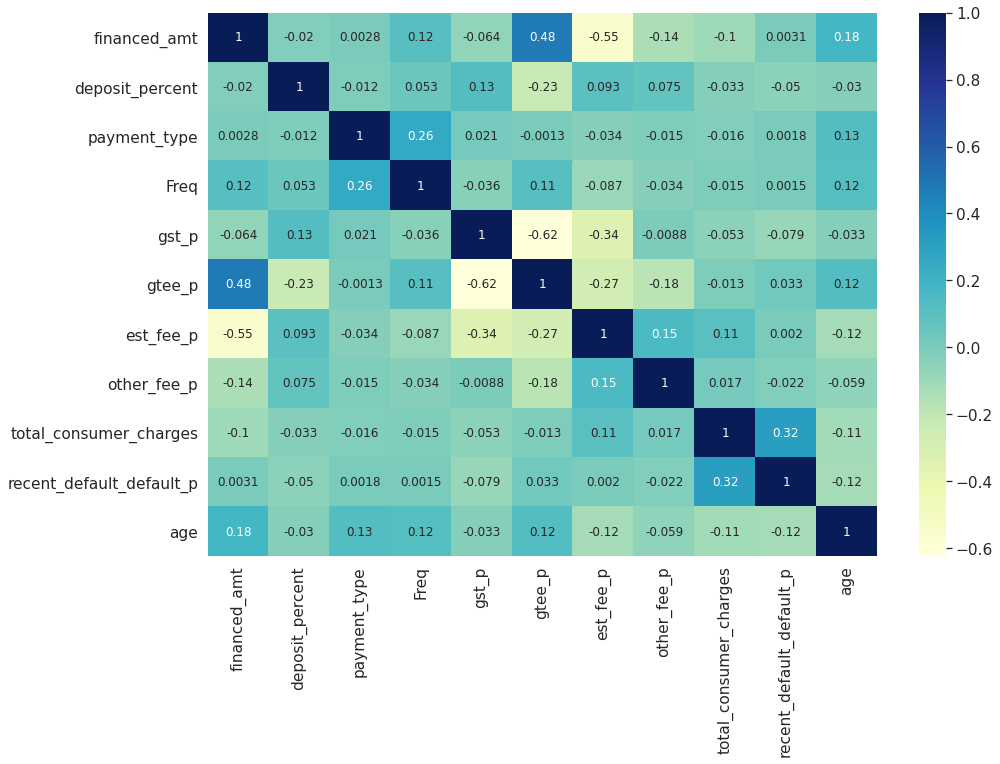

In [562]:
sns.set(font_scale=1.4) #坐标轴字号
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(df_cor.corr(), annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 12});  #方格中字号

In [563]:
df.head(3)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.00,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.00,1965.3,0.2219,576.93,0.0,0,0.0,576.93,0.0,576.93,0.221896,2010-11-26,0,0.00,0.0,0.00,0.00,0.0,,6530.0,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.000000,0.000000,0.000000,0.0,0.755885,0.0,0.0,0.221896,0.000000,0,45.928767
1,2,30000035,L30000035,ALARM,PaidInFull,2006-04-09,2006-09-13,2006H2,2006-09-20,3098.38,498.38,2600.00,48,0.160852,48,0,0,48,1,54.166667,2600.0,0.00,1965.3,0.2219,576.93,0.0,0,0.0,576.93,30.0,606.93,0.233435,2010-09-20,0,0.00,0.0,0.00,0.00,0.0,,6065.0,1944-10-31,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.000000,0.000000,0.000000,0.0,0.755885,0.0,0.0,0.221896,0.011538,0,61.479452
2,3,30000051,L30000051,ALARM,Default,2006-09-15,2006-09-27,2006H2,2006-05-10,2632.38,1000.00,1632.38,48,0.379884,48,0,0,48,1,34.007917,1496.0,136.38,1233.9,0.2219,362.22,0.0,0,0.0,362.22,0.0,362.22,0.221897,2010-05-10,277,136.38,277.0,136.38,136.38,0.0,,6157.0,1919-04-18,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.083547,0.083547,0.083547,0.0,0.755890,0.0,0.0,0.221897,0.000000,1,87.471233


# Step 5 Comparison Plot


## Categorical Variables - Product

In [0]:
# get product types (bought more than 1000 times)
product_types = product_df_new.index.to_list()

In [0]:
# build a new empty df

product_arrears_df = pd.DataFrame(index = product_types, 
                                  columns = ['no_arrears', 'has_arrears'])
product_arrears_df = product_arrears_df.fillna(0)

In [0]:
# get a list of counts of provided product types

def get_product_agg_df(types, k):
  """
  INPUT:
    k - has or no arrears (0 or 1)
  OUTPUT:
    a list of counts of provided product types
  """

  values = []

  df_temp = df[df['has_arrears']==k]

  for type in types:
    new_df = df_temp.query('Product == @type')['Product'].value_counts()

    new_df = new_df.rename_axis('type').reset_index(name='counts')
    new_df.set_index('type', inplace=True)

    n = new_df.loc[type]['counts']
    values.append(n)

  return values


In [0]:
# get the lists
product_counts_no_arr = get_product_agg_df(product_types, 0)
product_counts_has_arr = get_product_agg_df(product_types, 1)

# Fill the df 
product_arrears_df['no_arrears'] = product_counts_no_arr
product_arrears_df['has_arrears'] = product_counts_has_arr

In [0]:
def plot_compare_bar(x1, x2, xlabel):
  """
  x1, x2 - list of values
  xlabel - list of type names
  """

  data = [x1, x2]

  X = np.arange(len(xlabel))

  plt.figure(figsize=(16, 6))

  plt.bar(X + 0.0, data[0], color = my_color[0], width = 0.5)
  plt.bar(X + 0.5, data[1], color = my_color[1], width = 0.5)

  plt.xticks(X+0.25, xlabel, rotation = 90)

  colors = {'Never had arrears': my_color[0], 'Has had arrears':my_color[1]}         
  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)

  plt.show()


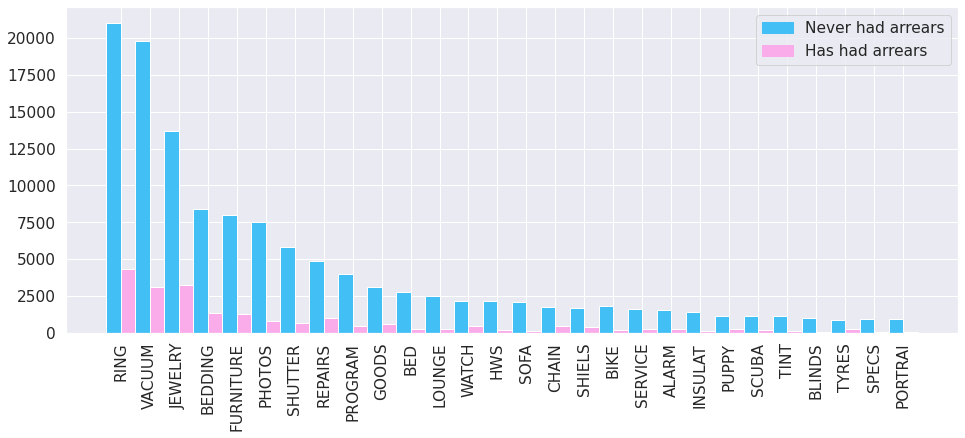

In [569]:
plot_compare_bar(product_counts_no_arr, product_counts_has_arr, product_types)

## Numerical Variables

### Purchase Amount

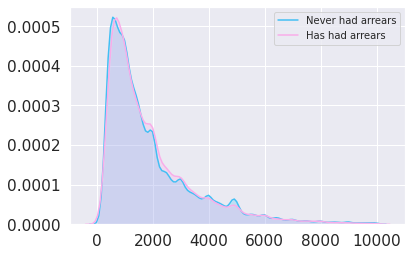

In [570]:
plot_compare_line('Purchase Amt', 10000)

## Financed Amount

In [0]:
df_new = pd.DataFrame(index = ['no_arrears', 'has_arrears'], 
                      columns = ['counts'])
df_new['counts'] = [df_0.shape[0],df_1.shape[0]]

In [572]:
df_new

,counts
no_arrears,237020
has_arrears,39526


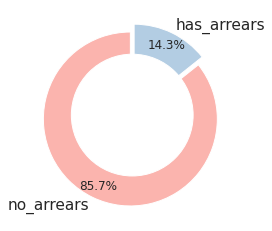

In [573]:
plot_donut(df_new)

In [574]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,1965.3,0.2219,576.93,0.0,0,0.0,576.93,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530.0,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.0,0.0,0.755885,0.0,0.0,0.221896,0.0,0,45.928767


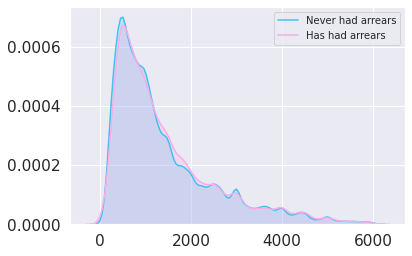

In [575]:
plot_compare_line('financed_amt', 6000)

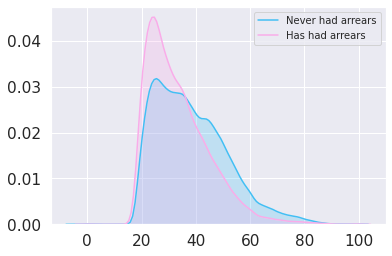

In [576]:
plot_compare_line('age', 100)

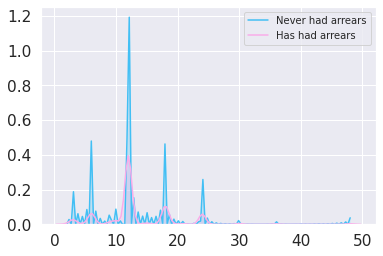

In [577]:
plot_compare_line('Term_Run', 100)

In [0]:
age_df = get_segments_df(df, 'age', 60, 20)

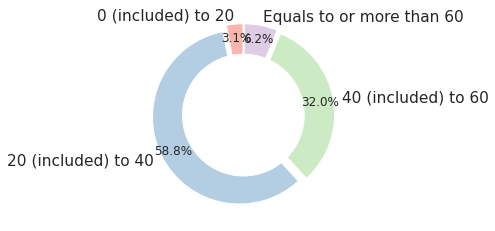

In [579]:
plot_donut(age_df)

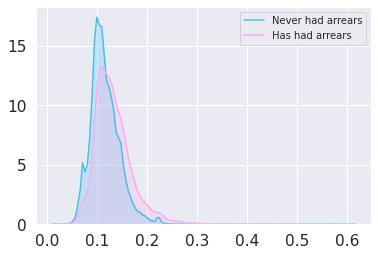

In [580]:
plot_compare_line('effective_billing_rate', 1)

In [0]:
e_b_df = get_pct_segments_df(df, 'effective_billing_rate', 0.2, 0.1)

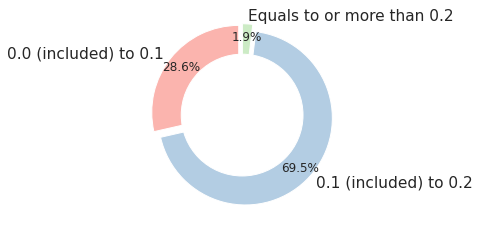

In [582]:
plot_donut(e_b_df)

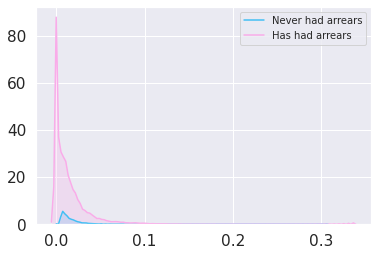

In [583]:
plot_compare_line('total_consumer_charges', 1)

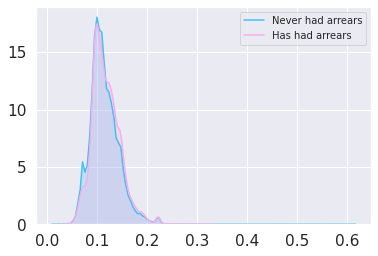

In [584]:
plot_compare_line('total_merchant_charge_p', 1)

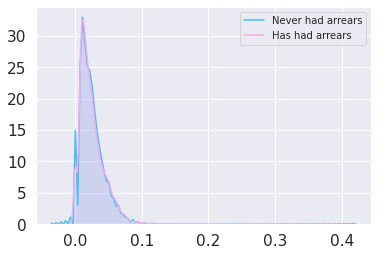

In [585]:
plot_compare_line('est_fee_p', 1)

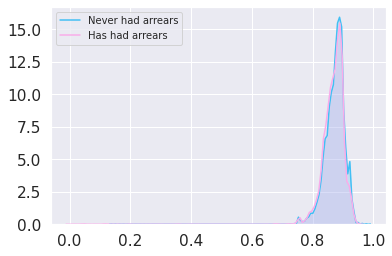

In [586]:
plot_compare_line('gst_p', 50)

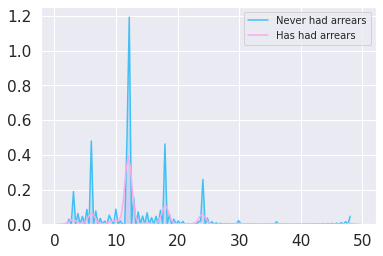

In [587]:
plot_compare_line('Total Term', 50)

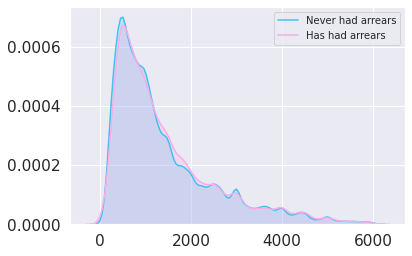

In [588]:
plot_compare_line('financed_amt', 6000)

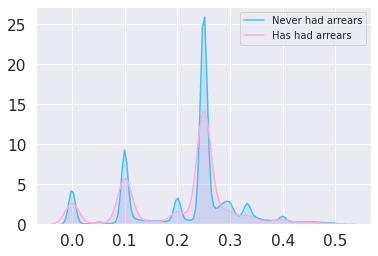

In [589]:
plot_compare_line('deposit_percent', 0.5)

# Step 6 Data Processing

In [590]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,1965.3,0.2219,576.93,0.0,0,0.0,576.93,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530.0,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.0,0.0,0.755885,0.0,0.0,0.221896,0.0,0,45.928767


In [0]:
features = ['financed_amt',      #贷款金额
            'deposit_percent',   #首付比例 p
            'payment_type',      #还款方式 0 / 1
            'Freq',              #还款频率 0 / 1
            'gst_p',             #GST和商家手续费费率 （占贷款金额的比例，以下同） p
            'gtee_p',            #银行担保费率 p
            'est_fee_p',         #开户费率 p
            'other_fee_p',       #其他费用费率 p
            'total_consumer_charges',    #客户所付费用费率 p
            'recent_default_default_p',  #最近一次逾期金额所占比例 p     
            'age',                #年龄
            'has_arrears'

]

In [592]:
df.head(1)

,Id,Contract_Number,Consumer_ID,Product,Contract_Status,Application_Date,Entry_Date,StartHalf,Fist Installment Date,Purchase Amt,Deposit Amt,financed_amt,Total Term,deposit_percent,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,gtee_p,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,Arrears Amount,No of Days in Arrears,DefaultAmount,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year of Birth,Merchant Number,Merchant Name,INdustry Name,Homowner Ind,Homowner Consumer,au_state,arrear_p,default_p,recent_default_default_p,recent_default_recov_p,gst_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,has_arrears,age
0,1,30000022,L30000022,ALARM,PaidInFull,2006-10-18,2006-01-11,2006H2,2006-11-26,3602.38,1002.38,2600.0,48,0.278255,48,0,0,48,1,54.166667,2600.0,0.0,1965.3,0.2219,576.93,0.0,0,0.0,576.93,0.0,576.93,0.221896,2010-11-26,0,0.0,0.0,0.0,0.0,0.0,,6530.0,1960-11-24,30112641,MODERN SECURITY WA,Home Security,1,1,WA,0.0,0.0,0.0,0.0,0.755885,0.0,0.0,0.221896,0.0,0,45.928767


In [593]:
# 归一化

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

df_para = df[features]
raw_col = ['financed_amt', 'age']

features_minmax_transform = pd.DataFrame(data = df_para)
features_minmax_transform[raw_col] = scaler.fit_transform(df_para[raw_col])

# Show an example of a record with scaling applied
display(features_minmax_transform.head(n = 5))

,financed_amt,deposit_percent,payment_type,Freq,gst_p,gtee_p,est_fee_p,other_fee_p,total_consumer_charges,recent_default_default_p,age,has_arrears
0,0.170569,0.278255,0,1,0.755885,0.2219,0.0,0.0,0.000000,0.000000,0.477777,0
1,0.170569,0.160852,0,1,0.755885,0.2219,0.0,0.0,0.011538,0.000000,0.625740,0
2,0.105845,0.379884,0,1,0.755890,0.2219,0.0,0.0,0.000000,0.083547,0.873048,1
3,0.170569,0.133333,0,1,0.755885,0.2219,0.0,0.0,0.000000,0.000000,0.498110,0
4,0.155343,0.112259,0,1,0.755908,0.2219,0.0,0.0,0.000000,0.000000,0.323167,0


In [0]:
from pandas.plotting import parallel_coordinates


In [0]:
#parallel_coordinates(df_para, 'has_arrears', color = my_color)
#plt.xticks(rotation=90)
#plt.show()

In [0]:
df_t = df_para[df_para['age'] > 0.9]


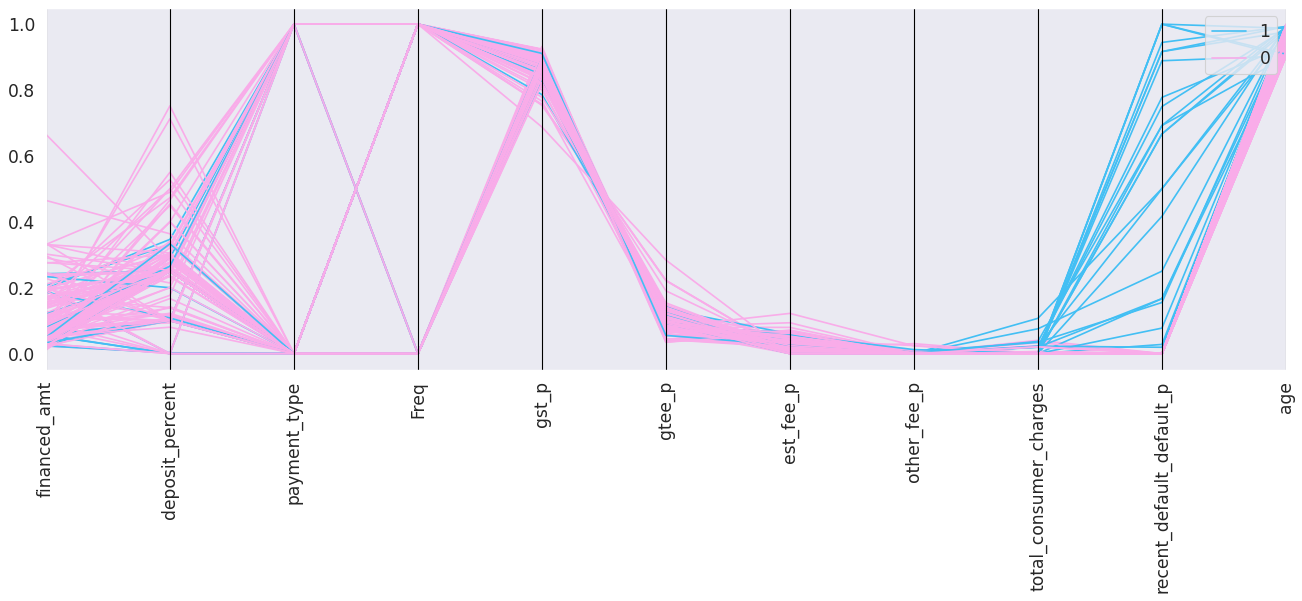

In [597]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
parallel_coordinates(df_t, 'has_arrears', color = my_color)

plt.xticks(rotation=90)
plt.show()

## Comparing Categorical Data in Bar Chart